In [2]:
import random 
import math
import matplotlib.pyplot as plt
import numpy as np

class Deck:
    def __init__(self):
        self.cards = [Card(s, v) for s in ["Spades" , "Clubs" , "Hearts ", 
        "Diamonds"] for v in ["A" ,"2" ,"3" ,"4" ,"5" ,"6" 
        ,"7" ,"8" ,"9" ,"10" , "J" , "Q" , "K"] ]
        
    def shuffle(self):
        if len(self.cards) > 1:
            random.shuffle(self.cards)
    
    def deal(self):
        if len(self.cards) > 1:
            return self.cards.pop(0)
    

class Card: 
    def __init__(self, suit , value): 
        self.suit = suit 
        self.value = value 
    
    def __repr__(self):
        return " of " .join((self.value , self.suit))
    
class Hand:
    def __init__(self , dealer = False):
        self.dealer = dealer 
        self.cards = []
        self.value = 0 
        self.has_ace = False

    def new_card(self, card):
        self.cards.append(card)

    def calculate_card_values(self):
        self.value = 0 
        self.has_ace = False
        for card in self.cards:
            if card.value.isnumeric():
                self.value += int(card.value)
            else:
                if card.value == "A":
                    self.has_ace = True
                    self.value += 11
                    if self.value > 21:
                        self.value -= 10 
                        self.has_ace = False
                else:
                    self.value += 10
        return self.value

    def show_cards(self, first_state):
        if self.dealer and first_state: 
            print("Hidden")
            print(self.cards[1])
        else:
            for card in self.cards: 
                print(card)
            print("Value:" , self.calculate_card_values())
    
    def return_dealer_card(self):
        card_val = self.cards[1].value
        if card_val.isnumeric():
            return card_val
        else:
            if card_val == "A":
                return 11
            else:
                return 10
            
class Agent:
    def __init__(self):
        pass
    
    def check(self, player_sum, dealer_card, player_has_ace):
        self.player_sum = player_sum
        self.dealer_card = dealer_card
        self.player_has_ace = player_has_ace
        
        if self.player_sum > 21 and self.player_has_ace == True:
            self.player_sum = player_sum - 10
            self.player_has_ace = False
        
        return self.player_sum, self.player_has_ace
        
        
class Game: 
    
    def __init__(self):
        self.reward = 0
        #creating agent for each enivornment
        self.agent = Agent() 
    
    def start_game(self, num_of_episodes, Q, exploring_starts, e_config = None):
        
        agent = self.agent
        
        game_ongoing = True
        first_state = True

        #print("Game Starting \n")
        
        self.deck = Deck()
        self.deck.shuffle()
        
        self.player_hand = Hand()
        self.dealer_hand = Hand(dealer=True)
        
        game_actions = []

        for i in range(2):
            card = self.deck.deal() 
            self.player_hand.new_card(card)
            card = self.deck.deal()
            self.dealer_hand.new_card(card)

        while game_ongoing == True: 
            
#             print("\nYour hand is:")
#             self.player_hand.show_cards(first_state)
#             print()
#             print("Dealer's hand is: ")
#             self.dealer_hand.show_cards(first_state)
            
            player_blackjack, dealer_blackjack = self.blackjack_check()

            if player_blackjack or dealer_blackjack:
                game_ongoing = False 
                outcome = self.blackjack_display_results(player_blackjack , dealer_blackjack)
                return outcome, game_actions
            
            
            player_hand_value = self.player_hand.calculate_card_values()
            dealer_hand_value = self.dealer_hand.calculate_card_values()
            
            
            #dealer card is only hidden before player plays first round
            if first_state == True:
                dealer_sum = self.dealer_hand.return_dealer_card()
            else:
                dealer_sum = dealer_hand_value
            
           
            player_hand_value, player_has_ace = agent.check(player_hand_value, dealer_sum, self.player_hand.has_ace)
            
            if player_hand_value < 12:
                choice = 1
            elif player_hand_value > 20:
                choice = 2
            else:
                #monte carlo
                if exploring_starts == True and first_state == True:
                    #random action (explore)
                    choice = random.randint(1,2) #either choose hit or stand

                else:
                    #action is selected randomly with probability 𝜖 and  greedily with probability 1 − 𝜖
                    
                    if exploring_starts == False and e_config == 2:
                        #for not exploring starts configuration 2 (epsilon = 𝑒^(−𝑘/1000) )
                        epsilon = pow(math.e, ((0-num_of_episodes)/1000))
                    elif exploring_starts == False and e_config == 3:
                        #for not exploring starts configuration 2 (epsilon = 𝑒^(−𝑘/10000) )
                        epsilon = pow(math.e, ((0-num_of_episodes)/10000))
                    else:
                        #for exploring starts or not exploring starts configuration 1 (epsilon = 1/k)
                        epsilon = 1/num_of_episodes
                    
                    random_num = random.random() #generating random number between 0 and 1
                    
                    #if random number < epsilon, random action will be chosen
                    if random_num < epsilon:
                        #random action (explore)
                        choice = random.randint(1,2) #either choose hit or stand
                    else:
                        #greedy
                        for k, v in Q.items():
                            if k == (player_hand_value, player_has_ace, dealer_hand_value):
                                #choosing the greatest q value
                                if v[1] > v[2]:
                                    #hit has greater q value
                                    choice = 1
                                elif v[1] < v[2]:
                                    #stand has greater q value
                                    choice = 2
                                else:
                                    #if both actions have equal value then choose random action
                                    choice = random.randint(1,2)
                
                #choice = reinforment_learning_algorithm(agent, self.player_hand, player_hand_value, self.dealer_hand.return_dealer_card(), self.player_hand.has_ace, self.deck.cards)
           
                #game actions only stored in Q table if between 12 and 20 
                game_actions.append([(player_hand_value, player_has_ace, dealer_hand_value), choice])
            
            if (choice == 1):
                #print("\nPlayer Hit")
                #player chose to hit
                self.player_hand.new_card(self.deck.deal())
                #self.player_hand.show_cards(first_state)
                player_hand_value = self.player_hand.calculate_card_values()
                if (player_hand_value > 21):
                    #print("\nPlayer has lost !")
                    game_ongoing = False
                    return -1, game_actions

            elif (choice == 2):
                #player chose to stand
                #print("\nPlayer Stand")
                
                first_state = False
                
                # Dealer Policy
                if dealer_hand_value < 17:
                    #print("\nDealer Hit")
                    self.dealer_hand.new_card(self.deck.deal())
                    #self.dealer_hand.show_cards(first_state)
                    dealer_hand_value = self.dealer_hand.calculate_card_values()
                    if (dealer_hand_value > 21):
                        #print("\nDealer has lost !")
                        game_ongoing = False
                        return 1, game_actions

#                 print("\nFinal Results:")
#                 print("Player's hand:" , player_hand_value)
#                 print("Dealer's hand:" , dealer_hand_value)
                
                if player_hand_value < 21 and dealer_hand_value < 21:
                    if (player_hand_value > dealer_hand_value):
                        #print("\nPlayer Wins!")
                        return 1, game_actions
                    elif (player_hand_value == dealer_hand_value):
                        #print("\nTie!")
                        return 0, game_actions
                    else: 
                        #print("\nDealer Wins!")
                        return -1, game_actions
                elif player_hand_value >= 21 and dealer_hand_value < 21:
                    #print("\nDealer Wins!")
                    return -1, game_actions
                elif dealer_hand_value >= 21 and player_hand_value < 21:
                    #print("\nPlayer Wins!")
                    return 1, game_actions
                else:
                    #print("\nTie!")
                    return 0, game_actions
            
                game_ongoing = False 
        
        first_state = False


    def blackjack_check(self):
        player = False 
        dealer = False
        
        if self.player_hand.calculate_card_values() == 21: 
            player = True
        if self.dealer_hand.calculate_card_values() == 21:
            dealer = True 

        return player, dealer 
    
    def blackjack_display_results(self , player_blackjack , dealer_blackjack):
        if player_blackjack and dealer_blackjack:
            #print("Both players have blackjack! Draw!")
            return 0

        elif player_blackjack: 
            #print("Player has blackjack! Player wins!")
            return 1
        
        elif dealer_blackjack:
            #print("Dealer has blackjack! Dealer wins!")
            return -1

def reinforment_learning_algorithm(agent, player_cards, player_sum, dealer_sum, player_has_ace, deck_cards):
    has_ace = player_has_ace
    agent.check(player_sum, dealer_sum, player_has_ace)
    
    hit_num = 0
    stand_num = 0
    hit_value = 0
    stand_value = 0

    if has_ace == player_has_ace:
        converted_ace = False
    else:
        converted_ace = True

    possible_outcomes = []

    if player_sum < 12:
        #Hit when sum is less than 12 
        hit_num = hit_num + 1
        choice = 1
    elif (player_sum == 21):
        stand_num = stand_num + 1
        # Stand if sum is equal to 21
        choice = 2
    elif(player_sum >= 12 and player_sum < 21):
        for possible_card in deck_cards:
            possible_cards = possible_card.value
            
            if '2' in possible_cards:
                possible_value = 2
            elif '3' in possible_cards:
                possible_value = 3
            elif '4' in possible_cards:
                possible_value = 4
            elif '5' in possible_cards:
                possible_value = 5
            elif '6' in possible_cards:
                possible_value = 6
            elif '7' in possible_cards:
                possible_value = 7
            elif '8' in possible_cards:
                possible_value = 8
            elif '9' in possible_cards:
                possible_value = 9
            elif '10' in possible_cards:
                possible_value = 10
            elif 'J' in possible_cards:
                possible_value = 10
            elif 'Q' in possible_cards:
                possible_value = 10
            elif 'K' in possible_cards:
                possible_value = 10
            elif 'A' in possible_cards:
                possible_value = 11

            player_total = player_sum + possible_value

            if player_total < 21:
                choice = 1 #to hit
                hit_num = hit_num + 1
                if hit_num == 1:
                    hit_value = player_total
                else:
                    hit_value = (hit_value + player_total)/2
            elif player_total >= 21 and possible_value == 11 and converted_ace == False and player_total-10 < 21:
                player_total = player_total - 10
                choice = 1 #to hit
                hit_num = hit_num + 1
                if hit_num == 1:
                    hit_value = player_total
                else:
                    hit_value = (hit_value + player_total)/2
            else:
                player_total = player_sum
                choice = 2 #to stand
                stand_num = stand_num + 1
                if stand_num == 1:
                    stand_value = player_total
                else:
                    stand_value = round((stand_value + player_total)/2)

            possible_outcomes.append([player_sum, possible_card, player_total, choice])

    print("Number of hits on action: ", hit_num)
    print("Number of stands on action: ", stand_num,"\n")
    print("Estimated hit value: ", round(hit_value),"\n")
    print("Estimated stand value: ", stand_value,"\n")
    #print(possible_outcomes, "\n")   

    if hit_num > stand_num:
        print("Hit")
        return 1 #to hit
    elif hit_num < stand_num:
        print("Stand")
        return 2 #to stand
    else:
        if hit_value > stand_value:
            print("Hit")
            return 1 # to hit
        else:
            print("Stand")
            return 2 #if equal then best option is to stand


### Config 1: Exploring States

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exited game
Exit

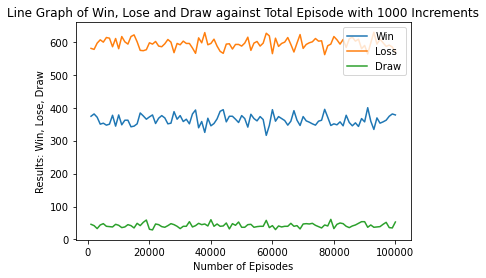

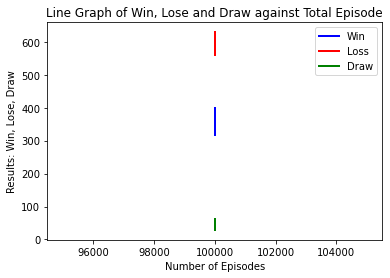

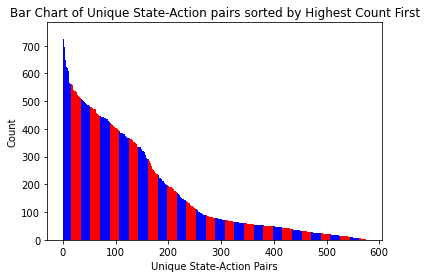


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'S'}, (13, 5): {0: 'S'}, (13, 6): {0: 'S'}, (13, 7): {0: 'H'}, (13, 8): {0: 'H'}, (13, 9): {0: 'H'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'S'}, (14, 5): {0: 'S'}, (14, 6): {0: 'S'}, (14, 7): {0: 'S'}, (14, 8): {0: 'S'}, (14, 9): {0: 'S'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'S'}, (15, 5): {0: 'S'}, (15, 6): {0: 'S'}, (15, 7): {0: 'S'}, (15, 8): {0: 'S'}, (15, 9): {0: 'S'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'S'}, (16, 5): {0: 'S'}, (16, 6): {0: 'S'}, (16, 7): {0: 'H'}, (16, 8): {0: 'S'}, (16, 9): {0: 'S'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'S'}, (17, 5): {0: 'S'}, (17, 6): {0: 

In [3]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 100000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = True, e_config = None)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
#     print("\nN: ",N)
#     print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique = num_unique + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique = num_unique + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
    if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
        for i in range(100): #to get the mean for last 100000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
    
        mean_win = mean_win/100000
        mean_loss = mean_loss/100000
        mean_draw = mean_draw/100000
    
#     if len(win) >= 2 and len(loss) >= 2 and len(draw)>= 2:
#         for i in range(2): #to get the mean for last 2000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
        
#         mean_win = mean_win/2000
#         mean_loss = mean_loss/2000
#         mean_draw = mean_draw/2000
    
    dealer_advantage_exploring = ((mean_loss-mean_win)/(mean_loss+mean_win))

Game Starting 


Your hand is:
3 of Clubs
3 of Hearts 
Value: 6

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
3 of Clubs
3 of Hearts 
8 of Spades
Value: 14

Your hand is:
3 of Clubs
3 of Hearts 
8 of Spades
Value: 14

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
3 of Clubs
3 of Hearts 
8 of Spades
4 of Diamonds
Value: 18

Your hand is:
3 of Clubs
3 of Hearts 
8 of Spades
4 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Hearts 
9 of Spades
Value: 13

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Dealer Hit
3 of Diamonds
7 of Spades
9 of Clubs
Value: 19

Final Results:
Player's hand: 13
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
8 of Clubs
Value: 14

Dealer's hand is: 
Hidden
3 of Hearts 

Player Hit
6 of Spades
8 of Clubs
4 of Diamonds
Value: 18

Your hand is:
6 of Spades
8 of Clubs
4 of Di

Game Starting 


Your hand is:
3 of Diamonds
2 of Diamonds
Value: 5

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
3 of Diamonds
2 of Diamonds
Q of Hearts 
Value: 15

Your hand is:
3 of Diamonds
2 of Diamonds
Q of Hearts 
Value: 15

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
5 of Spades
10 of Clubs
Q of Diamonds
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
J of Hearts 
Value: 21

Dealer's hand is: 
Hidden
A of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
10 of Clubs
4 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
8 of Diamonds
5 of Spades
7 of Diamonds
Value: 20

Final Results:
Player's hand: 14
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
6 of Spades
Value: 17

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
A of Spades
6 of Spades
8 of Diamonds
Value: 25

Player has lost !
Exited game
Game Starti

Game Starting 


Your hand is:
3 of Clubs
8 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
3 of Clubs
8 of Diamonds
A of Hearts 
Value: 12

Your hand is:
3 of Clubs
8 of Diamonds
A of Hearts 
Value: 12

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
3 of Clubs
8 of Diamonds
A of Hearts 
J of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Spades
3 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
6 of Spades
3 of Hearts 
5 of Diamonds
Value: 14

Your hand is:
6 of Spades
3 of Hearts 
5 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
7 of Diamonds

Player Stand

Dealer Hit
6 of Diamonds
7 of Diamonds
Q of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
J of Hearts 
3 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
A of Hearts 

Player Stand

Dealer Hit
5 of Hearts 
A of Hearts 
3 of Diamonds
Value: 19

Final Results:
Player's hand: 13
Dealer's hand: 19

Dealer Win

Game Starting 


Your hand is:
6 of Hearts 
J of Diamonds
Value: 16

Dealer's hand is: 
Hidden
J of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
6 of Clubs
5 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
6 of Clubs
5 of Hearts 
K of Clubs
Value: 21

Your hand is:
6 of Clubs
5 of Hearts 
K of Clubs
Value: 21

Dealer's hand is: 
Hidden
7 of Spades
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
2 of Hearts 
2 of Spades
Value: 4

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
2 of Hearts 
2 of Spades
K of Clubs
Value: 14

Your hand is:
2 of Hearts 
2 of Spades
K of Clubs
Value: 14

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Spades
4 of Spades
Value: 14

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
K of Spades
4 of Spades
10 of Diamonds
Value: 24

Player has lo

Game Starting 


Your hand is:
K of Clubs
9 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
3 of Clubs

Player Hit
K of Clubs
9 of Hearts 
A of Hearts 
Value: 20

Your hand is:
K of Clubs
9 of Hearts 
A of Hearts 
Value: 20

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
6 of Hearts 
3 of Clubs
J of Clubs
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
K of Diamonds
J of Clubs
Value: 20

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
6 of Hearts 
4 of Spades
5 of Hearts 
Value: 15

Final Results:
Player's hand: 20
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
6 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
2 of Spades

Player Stand

Dealer Hit
9 of Diamonds
2 of Spades
2 of Clubs
Value: 13

Final Results:
Player's hand: 16
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
K of Spades
Q of Diamonds
Value: 20

Dealer'

Game Starting 


Your hand is:
2 of Diamonds
2 of Spades
Value: 4

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
2 of Diamonds
2 of Spades
6 of Spades
Value: 10

Your hand is:
2 of Diamonds
2 of Spades
6 of Spades
Value: 10

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
2 of Diamonds
2 of Spades
6 of Spades
J of Hearts 
Value: 20

Your hand is:
2 of Diamonds
2 of Spades
6 of Spades
J of Hearts 
Value: 20

Dealer's hand is: 
Hidden
4 of Clubs

Player Stand

Dealer Hit
8 of Diamonds
4 of Clubs
A of Diamonds
Value: 13

Final Results:
Player's hand: 20
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
4 of Clubs
7 of Spades
Value: 11

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
4 of Clubs
7 of Spades
K of Hearts 
Value: 21

Your hand is:
4 of Clubs
7 of Spades
K of Hearts 
Value: 21

Dealer's hand is: 
Hidden
9 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Clubs
K of Diamonds
Value: 20

Dealer's hand is: 
Hid

Game Starting 


Your hand is:
7 of Clubs
8 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
Q of Hearts 

Player Stand

Dealer Hit
3 of Hearts 
Q of Hearts 
9 of Spades
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
6 of Clubs
4 of Hearts 
Value: 10

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
6 of Clubs
4 of Hearts 
8 of Spades
Value: 18

Your hand is:
6 of Clubs
4 of Hearts 
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Dealer Hit
2 of Diamonds
Q of Diamonds
J of Spades
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Clubs
7 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
A of Spades
3 of Diamonds
Q of Spades
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Clubs
9 of Spades
Value: 19

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
7 of Diamonds
4 of Spades
3 of Clubs
Value: 14

Final Results:
Player's hand

Game Starting 


Your hand is:
Q of Diamonds
4 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
9 of Hearts 
3 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
9 of Hearts 
3 of Diamonds
8 of Clubs
Value: 20

Your hand is:
9 of Hearts 
3 of Diamonds
8 of Clubs
Value: 20

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
A of Hearts 
Value: 16

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Dealer Hit
4 of Spades
J of Diamonds
A of Hearts 
Value: 15

Final Results:
Player's hand: 20
Dealer's hand: 15

Player W

Game Starting 


Your hand is:
A of Hearts 
2 of Spades
Value: 13

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
5 of Diamonds
10 of Clubs
3 of Diamonds
Value: 18

Final Results:
Player's hand: 13
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
3 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
6 of Spades
3 of Hearts 
10 of Spades
Value: 19

Your hand is:
6 of Spades
3 of Hearts 
10 of Spades
Value: 19

Dealer's hand is: 
Hidden
9 of Spades

Player Stand

Dealer Hit
4 of Diamonds
9 of Spades
10 of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
6 of Hearts 
5 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
6 of Hearts 
5 of Diamonds
Q of Spades
Value: 21

Your hand is:
6 of Hearts 
5 of Diamonds
Q of Spades
Value: 21

Dealer's hand is: 
Hidden
5 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
4 of Clubs
Q of Diam

Game Starting 


Your hand is:
5 of Hearts 
J of Diamonds
Value: 15

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
5 of Hearts 
J of Diamonds
K of Diamonds
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Diamonds
4 of Hearts 
Value: 7

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
3 of Diamonds
4 of Hearts 
5 of Clubs
Value: 12

Your hand is:
3 of Diamonds
4 of Hearts 
5 of Clubs
Value: 12

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
3 of Diamonds
4 of Hearts 
5 of Clubs
K of Spades
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Hearts 
3 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
6 of Diamonds

Player Hit
8 of Hearts 
3 of Diamonds
K of Hearts 
Value: 21

Your hand is:
8 of Hearts 
3 of Diamonds
K of Hearts 
Value: 21

Dealer's hand is: 
Hidden
6 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
10 of Clubs
10 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
2 of Spades

Game Starting 


Your hand is:
9 of Spades
6 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
9 of Spades
6 of Hearts 
K of Spades
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Diamonds
3 of Hearts 
Value: 5

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
2 of Diamonds
3 of Hearts 
K of Clubs
Value: 15

Your hand is:
2 of Diamonds
3 of Hearts 
K of Clubs
Value: 15

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
2 of Diamonds
3 of Hearts 
K of Clubs
10 of Hearts 
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Clubs
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
A of Hearts 
3 of Diamonds
9 of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
9 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
A of Spades
9 of Diamonds
A of Clubs
Value: 21

Your hand is:
A of Spades
9 of Diamonds
A of Clu

Game Starting 


Your hand is:
K of Clubs
5 of Clubs
Value: 15

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
K of Clubs
5 of Clubs
A of Clubs
Value: 16

Your hand is:
K of Clubs
5 of Clubs
A of Clubs
Value: 16

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
K of Clubs
5 of Clubs
A of Clubs
6 of Clubs
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Spades
9 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
2 of Spades
9 of Diamonds
9 of Clubs
Value: 20

Your hand is:
2 of Spades
9 of Diamonds
9 of Clubs
Value: 20

Dealer's hand is: 
Hidden
5 of Clubs

Player Stand

Dealer Hit
K of Diamonds
5 of Clubs
5 of Hearts 
Value: 20

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
5 of Clubs
7 of Spades
Value: 12

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
Q of Diamonds
5 of Diamonds
9 of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand i

Game Starting 


Your hand is:
A of Diamonds
K of Diamonds
Value: 21

Dealer's hand is: 
Hidden
J of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
K of Spades
Value: 20

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
5 of Hearts 
9 of Spades
Value: 14

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
5 of Hearts 
9 of Spades
6 of Spades
Value: 20

Your hand is:
5 of Hearts 
9 of Spades
6 of Spades
Value: 20

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
8 of Clubs
Value: 19

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
Q of Spades
3 of Spades
J of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
7 of Clubs
Q of Diamonds
Value: 17

Dealer's h

Game Starting 


Your hand is:
A of Spades
9 of Clubs
Value: 20

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Dealer Hit
4 of Clubs
K of Diamonds
10 of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Hearts 
A of Diamonds
Value: 15

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Dealer Hit
2 of Diamonds
10 of Hearts 
6 of Spades
Value: 18

Final Results:
Player's hand: 15
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A of Diamonds
3 of Spades
Value: 14

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
Q of Spades
4 of Hearts 
8 of Diamonds
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Hearts 
5 of Spades
Value: 15

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Dealer Hit
2 of Clubs
K of Diamonds
K of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Hearts 
10 of Spades
Value: 20

Dealer's hand is: 
Hidden
K of Spades

Game Starting 


Your hand is:
5 of Spades
4 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
5 of Spades
4 of Hearts 
6 of Spades
Value: 15

Your hand is:
5 of Spades
4 of Hearts 
6 of Spades
Value: 15

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
7 of Clubs
6 of Clubs
10 of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Hearts 
4 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
5 of Hearts 
4 of Diamonds
8 of Spades
Value: 17

Your hand is:
5 of Hearts 
4 of Diamonds
8 of Spades
Value: 17

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
2 of Diamonds
4 of Spades
10 of Hearts 
Value: 16

Final Results:
Player's hand: 17
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
K of Diamonds
Value: 17

Dealer's hand is: 
Hidden
2 of Spades

Player Stand

Dealer Hit
6 of Clubs
2 of Spades
8 of Hearts 
Value: 16

Final Results:
Player's hand: 17

Player Stand

Dealer Hit
4 of Clubs
J of Hearts 
9 of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Spades
A of Spades
Value: 16

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
5 of Spades
A of Spades
5 of Clubs
Value: 21

Your hand is:
5 of Spades
A of Spades
5 of Clubs
Value: 21

Dealer's hand is: 
Hidden
3 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
7 of Clubs
A of Clubs
Value: 18

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
7 of Clubs
A of Clubs
10 of Diamonds
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Hearts 
K of Spades
Value: 20

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
10 of Clubs
3 of Spades
6 of Spades
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
J of Spades
Value: 20

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
J of He

Game Starting 


Your hand is:
3 of Spades
3 of Diamonds
Value: 6

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
3 of Spades
3 of Diamonds
7 of Clubs
Value: 13

Your hand is:
3 of Spades
3 of Diamonds
7 of Clubs
Value: 13

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
6 of Spades
2 of Diamonds
5 of Hearts 
Value: 13

Final Results:
Player's hand: 13
Dealer's hand: 13

Tie!
Exited game
Game Starting 


Your hand is:
K of Spades
Q of Hearts 
Value: 20

Dealer's hand is: 
Hidden
A of Clubs
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
A of Diamonds
Value: 17

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Dealer Hit
4 of Clubs
Q of Clubs
Q of Diamonds
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
9 of Clubs
Value: 20

Dealer's hand is: 
Hidden
9 of Spades

Player Stand

Dealer Hit
6 of Clubs
9 of Spades
5 of Spades
Value: 20

Final Results:
Player's hand: 20
Dealer's hand: 20



Game Starting 


Your hand is:
J of Diamonds
A of Spades
Value: 21

Dealer's hand is: 
Hidden
8 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
J of Diamonds
J of Hearts 
Value: 20

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Dealer Hit
4 of Hearts 
7 of Hearts 
Q of Hearts 
Value: 21

Final Results:
Player's hand: 20
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Clubs
8 of Spades
Value: 11

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
3 of Clubs
8 of Spades
2 of Diamonds
Value: 13

Your hand is:
3 of Clubs
8 of Spades
2 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
3 of Clubs
8 of Spades
2 of Diamonds
Q of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Hearts 
7 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
8 of Hearts 
7 of Diamonds
2 of Spades
Value: 17

Your hand is:
8 of Hearts 
7 of Diamonds
2 of Spades
V

Game Starting 


Your hand is:
Q of Spades
8 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
Q of Spades
8 of Diamonds
3 of Diamonds
Value: 21

Your hand is:
Q of Spades
8 of Diamonds
3 of Diamonds
Value: 21

Dealer's hand is: 
Hidden
9 of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
4 of Hearts 
7 of Clubs
Value: 11

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
4 of Hearts 
7 of Clubs
3 of Diamonds
Value: 14

Your hand is:
4 of Hearts 
7 of Clubs
3 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
Q of Hearts 

Player Stand

Dealer Hit
5 of Hearts 
Q of Hearts 
A of Clubs
Value: 16

Final Results:
Player's hand: 14
Dealer's hand: 16

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Hearts 
A of Hearts 
Value: 13

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
2 of Hearts 
A of Hearts 
Q of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
Q of Spades
Value: 2

Game Starting 


Your hand is:
7 of Clubs
K of Clubs
Value: 17

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
A of Hearts 
6 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
A of Spades

Player Hit
A of Hearts 
6 of Diamonds
3 of Spades
Value: 20

Your hand is:
A of Hearts 
6 of Diamonds
3 of Spades
Value: 20

Dealer's hand is: 
Hidden
A of Spades

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
A of Spades
5 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
10 of Clubs
Value: 12

Dealer's hand is: 
Hidden
A of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
9 of Spades
8 of Clubs
Value: 17

Dealer's hand is: 
Hidden
7 of Diamonds

Pl

Game Starting 


Your hand is:
J of Spades
5 of Clubs
Value: 15

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
J of Spades
5 of Clubs
10 of Hearts 
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Clubs
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
A of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
8 of Hearts 

Player Stand

Dealer Hit
2 of Hearts 
8 of Hearts 
J of Spades
Value: 20

Final Results:
Player's hand: 18
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Diamonds
9 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
K of Spades

Player Hit
4 of Diamonds
9 of Hearts 
J of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Spades
4 of Diamonds
Value: 6

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
2 of Spades
4 of Diamonds
5 of Hearts 
Value: 11

Your hand is:
2 of Spades

Game Starting 


Your hand is:
2 of Diamonds
K of Clubs
Value: 12

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
2 of Diamonds
K of Clubs
5 of Clubs
Value: 17

Your hand is:
2 of Diamonds
K of Clubs
5 of Clubs
Value: 17

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Clubs
2 of Clubs
Value: 12

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
Q of Clubs
2 of Clubs
9 of Hearts 
Value: 21

Your hand is:
Q of Clubs
2 of Clubs
9 of Hearts 
Value: 21

Dealer's hand is: 
Hidden
K of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
K of Diamonds
Q of Spades
Value: 20

Dealer's hand is: 
Hidden
K of Spades

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
9 of Diamonds
Q of Spades
Value: 19

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
A of Spade

Game Starting 


Your hand is:
2 of Clubs
A of Diamonds
Value: 13

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
2 of Clubs
A of Diamonds
7 of Hearts 
Value: 20

Your hand is:
2 of Clubs
A of Diamonds
7 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
K of Clubs
3 of Diamonds
A of Clubs
Value: 14

Final Results:
Player's hand: 20
Dealer's hand: 14

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Clubs
2 of Spades
Value: 10

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
8 of Clubs
2 of Spades
9 of Spades
Value: 19

Your hand is:
8 of Clubs
2 of Spades
9 of Spades
Value: 19

Dealer's hand is: 
Hidden
5 of Clubs

Player Stand

Dealer Hit
6 of Spades
5 of Clubs
7 of Hearts 
Value: 18

Final Results:
Player's hand: 19
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Hearts 
Q of Spades
Value: 21

Dealer's hand is: 
Hidden
7 of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Yo

Game Starting 


Your hand is:
6 of Hearts 
A of Spades
Value: 17

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
6 of Hearts 
A of Spades
3 of Hearts 
Value: 20

Your hand is:
6 of Hearts 
A of Spades
3 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
9 of Spades

Player Stand

Dealer Hit
7 of Spades
9 of Spades
4 of Hearts 
Value: 20

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
4 of Clubs
Value: 9

Dealer's hand is: 
Hidden
8 of Spades

Player Hit
5 of Diamonds
4 of Clubs
10 of Diamonds
Value: 19

Your hand is:
5 of Diamonds
4 of Clubs
10 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
8 of Spades

Player Stand

Dealer Hit
3 of Clubs
8 of Spades
6 of Clubs
Value: 17

Final Results:
Player's hand: 19
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
2 of Clubs
Value: 7

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
5 of Diamonds
2 of Clubs
3 of Diamonds
Value: 10

Your h

Game Starting 


Your hand is:
K of Spades
6 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
K of Spades
6 of Diamonds
2 of Hearts 
Value: 18

Your hand is:
K of Spades
6 of Diamonds
2 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
J of Diamonds
6 of Clubs
J of Spades
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Hearts 
3 of Clubs
Value: 8

Dealer's hand is: 
Hidden
A of Hearts 

Player Hit
5 of Hearts 
3 of Clubs
6 of Hearts 
Value: 14

Your hand is:
5 of Hearts 
3 of Clubs
6 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
A of Hearts 

Player Hit
5 of Hearts 
3 of Clubs
6 of Hearts 
5 of Clubs
Value: 19

Your hand is:
5 of Hearts 
3 of Clubs
6 of Hearts 
5 of Clubs
Value: 19

Dealer's hand is: 
Hidden
A of Hearts 

Player Stand

Dealer Hit
A of Clubs
A of Hearts 
8 of Clubs
Value: 20

Final Results:
Player's hand: 19
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:


Game Starting 


Your hand is:
K of Hearts 
9 of Clubs
Value: 19

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
10 of Spades
4 of Hearts 
5 of Diamonds
Value: 19

Final Results:
Player's hand: 19
Dealer's hand: 19

Tie!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
10 of Clubs
Value: 16

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
6 of Diamonds
10 of Clubs
K of Spades
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Clubs
K of Spades
Value: 21

Dealer's hand is: 
Hidden
J of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
J of Spades
2 of Spades
Value: 12

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
J of Spades
2 of Spades
K of Hearts 
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Hearts 
A of Diamonds
Value: 19

Dealer's hand is: 
Hidden
A of Clubs
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
5 of Hearts 
2 of Spad

Game Starting 


Your hand is:
7 of Diamonds
4 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
A of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
10 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
7 of Hearts 
10 of Hearts 
7 of Diamonds
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Spades
3 of Diamonds
Value: 5

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
2 of Spades
3 of Diamonds
6 of Clubs
Value: 11

Your hand is:
2 of Spades
3 of Diamonds
6 of Clubs
Value: 11

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
2 of Spades
3 of Diamonds
6 of Clubs
2 of Diamonds
Value: 13

Your hand is:
2 of Spades
3 of Diamonds
6 of Clubs
2 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
2 of Spades
3 of Diamonds
6 of Clubs
2 of Diamonds
A of Clubs
Value: 14

Your hand is:
2 of Spades
3 of Diamonds
6 of Clubs
2 of Diamonds
A of Clubs
Value: 14

Dealer's ha

Game Starting 


Your hand is:
K of Hearts 
8 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
9 of Diamonds
6 of Clubs
6 of Spades
Value: 21

Final Results:
Player's hand: 18
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Hearts 
8 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
3 of Hearts 
8 of Diamonds
9 of Clubs
Value: 20

Your hand is:
3 of Hearts 
8 of Diamonds
9 of Clubs
Value: 20

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
4 of Spades
2 of Hearts 
Value: 6

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
4 of Spades
2 of Hearts 
3 of Hearts 
Value: 9

Your hand is:
4 of Spades
2 of Hearts 
3 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
4 of Spades
2 of Hearts 
3 of Hearts 
8 of Spades
Value: 17

Your hand is:
4 of Spades
2 of Hearts 
3 of Hearts 
8 of

Game Starting 


Your hand is:
2 of Clubs
J of Hearts 
Value: 12

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
2 of Clubs
J of Hearts 
10 of Clubs
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Spades
10 of Spades
Value: 19

Dealer's hand is: 
Hidden
8 of Spades

Player Stand

Dealer Hit
5 of Clubs
8 of Spades
K of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
8 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
3 of Hearts 
8 of Diamonds
7 of Spades
Value: 18

Your hand is:
3 of Hearts 
8 of Diamonds
7 of Spades
Value: 18

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
10 of Spades
5 of Spades
J of Clubs
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Spades
6 of Clubs
Value: 11

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
5 of Spades
6 of Clubs
A of Clubs
Value: 12

Your hand is:
5 of Spades
6 of Clubs
A of Clubs
Value: 12

Dealer'



Your hand is:
K of Spades
9 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Dealer Hit
8 of Clubs
6 of Spades
8 of Spades
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Hearts 
9 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
10 of Diamonds

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
6 of Diamonds
Value: 8

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
2 of Diamonds
6 of Diamonds
K of Clubs
Value: 18

Your hand is:
2 of Diamonds
6 of Diamonds
K of Clubs
Value: 18

Dealer's hand is: 
Hidden
4 of Clubs

Player Stand

Dealer Hit
A of Hearts 
4 of Clubs
K of Diamonds
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
3 of Spades
K of Clubs
Value: 13

Dealer's hand is: 
Hidden
5 of Hearts 

Player Stand

Dealer Hit
Q of Clubs
5 of Hearts 
6 of Diamonds
Value: 21

Final Results:
Player's hand: 13
Dealer's hand: 21



Game Starting 


Your hand is:
5 of Hearts 
Q of Diamonds
Value: 15

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
5 of Hearts 
Q of Diamonds
4 of Spades
Value: 19

Your hand is:
5 of Hearts 
Q of Diamonds
4 of Spades
Value: 19

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
A of Clubs
3 of Spades
J of Diamonds
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
6 of Hearts 
4 of Clubs
Value: 10

Dealer's hand is: 
Hidden
8 of Diamonds

Player Hit
6 of Hearts 
4 of Clubs
6 of Diamonds
Value: 16

Your hand is:
6 of Hearts 
4 of Clubs
6 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
8 of Diamonds

Player Hit
6 of Hearts 
4 of Clubs
6 of Diamonds
A of Hearts 
Value: 17

Your hand is:
6 of Hearts 
4 of Clubs
6 of Diamonds
A of Hearts 
Value: 17

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
J of Spades
A of Clubs
Value: 21

Dealer's hand is

Game Starting 


Your hand is:
7 of Hearts 
Q of Diamonds
Value: 17

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand

Dealer Hit
6 of Clubs
9 of Diamonds
A of Spades
Value: 16

Final Results:
Player's hand: 17
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
8 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
5 of Diamonds
8 of Diamonds
2 of Spades
Value: 15

Your hand is:
5 of Diamonds
8 of Diamonds
2 of Spades
Value: 15

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
5 of Diamonds
8 of Diamonds
2 of Spades
9 of Hearts 
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Spades
6 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
3 of Spades
6 of Diamonds
5 of Hearts 
Value: 14

Your hand is:
3 of Spades
6 of Diamonds
5 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
3 of Spades
6 of Diamonds
5 of Hearts 
10 of Clubs
Value: 24

Player has 

Game Starting 


Your hand is:
4 of Clubs
3 of Clubs
Value: 7

Dealer's hand is: 
Hidden
A of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
Q of Diamonds
Value: 16

Dealer's hand is: 
Hidden
Q of Hearts 

Player Stand

Dealer Hit
4 of Clubs
Q of Hearts 
A of Hearts 
Value: 15

Final Results:
Player's hand: 16
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
10 of Spades
5 of Clubs
Value: 15

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
10 of Spades
5 of Clubs
4 of Hearts 
Value: 19

Your hand is:
10 of Spades
5 of Clubs
4 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 19

Tie!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
8 of Clubs
Value: 10

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
2 of Diamonds
8 of Clubs
5 of Clubs
Value: 15

Your hand is:
2 of Diamonds
8 of Clubs
5 of Clubs
Value: 15

Dealer's hand i



Your hand is:
2 of Clubs
8 of Spades
Value: 10

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
2 of Clubs
8 of Spades
3 of Hearts 
Value: 13

Your hand is:
2 of Clubs
8 of Spades
3 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
2 of Clubs
8 of Spades
3 of Hearts 
2 of Hearts 
Value: 15

Your hand is:
2 of Clubs
8 of Spades
3 of Hearts 
2 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
3 of Spades
10 of Clubs
K of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
J of Clubs
2 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
J of Clubs
2 of Diamonds
Q of Spades
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Hearts 
Q of Clubs
Value: 16

Dealer's hand is: 
Hidden
2 of Spades

Player Stand

Dealer Hit
10 of Clubs
2 of Spades
J of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Diamonds
4 of Hearts 
Value:

Game Starting 


Your hand is:
6 of Clubs
8 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Dealer Hit
2 of Spades
8 of Clubs
3 of Diamonds
Value: 13

Final Results:
Player's hand: 14
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Clubs
Q of Diamonds
Value: 18

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
K of Hearts 
4 of Spades
7 of Clubs
Value: 21

Final Results:
Player's hand: 18
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
8 of Clubs
Value: 19

Dealer's hand is: 
Hidden
J of Spades

Player Hit
A of Spades
8 of Clubs
2 of Hearts 
Value: 21

Your hand is:
A of Spades
8 of Clubs
2 of Hearts 
Value: 21

Dealer's hand is: 
Hidden
J of Spades
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
J of Hearts 
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
J of Hearts 
8 of Spades
A of Hearts 
Value: 19

Your hand is:
J o

Game Starting 


Your hand is:
8 of Diamonds
8 of Spades
Value: 16

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
J of Spades
2 of Clubs
6 of Diamonds
Value: 18

Final Results:
Player's hand: 16
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Diamonds
4 of Clubs
Value: 8

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
4 of Diamonds
4 of Clubs
10 of Diamonds
Value: 18

Your hand is:
4 of Diamonds
4 of Clubs
10 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
4 of Diamonds
4 of Clubs
10 of Diamonds
2 of Diamonds
Value: 20

Your hand is:
4 of Diamonds
4 of Clubs
10 of Diamonds
2 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Hearts 
A of Clubs
Value: 12

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
9 of Spades
3 of Clubs
J of Spades
Value: 22

Dealer has lost 

Game Starting 


Your hand is:
2 of Spades
7 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
3 of Clubs

Player Hit
2 of Spades
7 of Hearts 
7 of Diamonds
Value: 16

Your hand is:
2 of Spades
7 of Hearts 
7 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
2 of Diamonds
3 of Clubs
Q of Spades
Value: 15

Final Results:
Player's hand: 16
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
5 of Spades
10 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
10 of Clubs
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
3 of Clubs
K of Clubs
Value: 13

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
3 of Clubs
K of Clubs
6 of Diamonds
Value: 19

Your hand is:
3 of Clubs
K of Clubs
6 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
3 of Clubs
K of Clubs
6 of Diamonds
7 of Hearts 
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Clubs
A of Clubs
Value: 19



Game Starting 


Your hand is:
K of Hearts 
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
7 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
J of Clubs
7 of Hearts 
3 of Diamonds
Value: 20

Your hand is:
J of Clubs
7 of Hearts 
3 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Dealer Hit
2 of Spades
7 of Spades
9 of Clubs
Value: 18

Final Results:
Player's hand: 20
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
K of Hearts 
K of Spades
Value: 20

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
6 of Spades
5 of Diamonds
10 of Spades
Value: 21

Final Results:
Player's hand: 20
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
K of Spades
5 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
J of Diamonds
Dealer has blackjack

Game Starting 


Your hand is:
A of Hearts 
6 of Spades
Value: 17

Dealer's hand is: 
Hidden
5 of Hearts 

Player Hit
A of Hearts 
6 of Spades
Q of Hearts 
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Diamonds
J of Hearts 
Value: 17

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
4 of Clubs
4 of Hearts 
8 of Spades
Value: 16

Final Results:
Player's hand: 17
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
9 of Diamonds
K of Spades
Value: 19

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Clubs
3 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
A of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
Q of Diamonds
4 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
Q of Diamonds
4 of Diamonds
7 of Clubs
Value: 21

Your hand is:
Q of Di

Game Starting 


Your hand is:
5 of Diamonds
8 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Dealer Hit
3 of Diamonds
A of Diamonds
J of Diamonds
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Spades
A of Spades
Value: 21

Dealer's hand is: 
Hidden
Q of Diamonds
Both players have blackjack! Draw!
Exited game
Game Starting 


Your hand is:
3 of Clubs
7 of Clubs
Value: 10

Dealer's hand is: 
Hidden
6 of Diamonds

Player Hit
3 of Clubs
7 of Clubs
2 of Diamonds
Value: 12

Your hand is:
3 of Clubs
7 of Clubs
2 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
6 of Diamonds

Player Hit
3 of Clubs
7 of Clubs
2 of Diamonds
K of Spades
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Clubs
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Dealer Hit
9 of Diamonds
7 of Hearts 
J of Hearts 
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Hearts 
3 of Dia

Game Starting 


Your hand is:
J of Hearts 
2 of Spades
Value: 12

Dealer's hand is: 
Hidden
A of Hearts 

Player Hit
J of Hearts 
2 of Spades
7 of Hearts 
Value: 19

Your hand is:
J of Hearts 
2 of Spades
7 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
A of Hearts 

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
5 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
6 of Spades
5 of Diamonds
7 of Clubs
Value: 18

Your hand is:
6 of Spades
5 of Diamonds
7 of Clubs
Value: 18

Dealer's hand is: 
Hidden
8 of Hearts 

Player Stand

Dealer Hit
8 of Clubs
8 of Hearts 
8 of Spades
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
3 of Spades
A of Hearts 
Value: 14

Dealer's hand is: 
Hidden
8 of Hearts 

Player Stand

Dealer Hit
6 of Hearts 
8 of Hearts 
A of Spades
Value: 15

Final Results:
Player's hand: 14
Dealer's hand: 15

Dealer Wins!
Exited game
Game Start

Game Starting 


Your hand is:
6 of Hearts 
5 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
6 of Hearts 
5 of Hearts 
9 of Diamonds
Value: 20

Your hand is:
6 of Hearts 
5 of Hearts 
9 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Dealer Hit
2 of Clubs
A of Diamonds
6 of Spades
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
5 of Spades
Value: 12

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
5 of Diamonds
10 of Clubs
3 of Clubs
Value: 18

Final Results:
Player's hand: 12
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A of Clubs
7 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
A of Clubs
7 of Diamonds
10 of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Spades
J of Hearts 
Value: 20

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Game Starting 


Your hand is:
3 of Hearts 
A of Hearts 
Value: 14

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
6 of Clubs
10 of Clubs
5 of Spades
Value: 21

Final Results:
Player's hand: 14
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
4 of Clubs
A of Hearts 
Value: 15

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
4 of Clubs
A of Hearts 
2 of Clubs
Value: 17

Your hand is:
4 of Clubs
A of Hearts 
2 of Clubs
Value: 17

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
K of Hearts 
3 of Spades
7 of Hearts 
Value: 20

Final Results:
Player's hand: 17
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Clubs
A of Hearts 
Value: 17

Dealer's hand is: 
Hidden
8 of Spades

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
4 of

Game Starting 


Your hand is:
6 of Clubs
8 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
6 of Clubs
8 of Diamonds
4 of Hearts 
Value: 18

Your hand is:
6 of Clubs
8 of Diamonds
4 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 18

Tie!
Exited game
Game Starting 


Your hand is:
10 of Spades
10 of Clubs
Value: 20

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Clubs
5 of Diamonds
Value: 8

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
3 of Clubs
5 of Diamonds
K of Spades
Value: 18

Your hand is:
3 of Clubs
5 of Diamonds
K of Spades
Value: 18

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
3 of Clubs
5 of Diamonds
K of Spades
K of Clubs
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Spades
3 of Hearts 
Value: 11

Dealer's han

Game Starting 


Your hand is:
5 of Diamonds
K of Hearts 
Value: 15

Dealer's hand is: 
Hidden
8 of Hearts 

Player Stand

Dealer Hit
5 of Spades
8 of Hearts 
7 of Spades
Value: 20

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
J of Spades
A of Hearts 
Value: 21

Dealer's hand is: 
Hidden
Q of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
9 of Clubs
Q of Hearts 
Value: 19

Dealer's hand is: 
Hidden
5 of Hearts 

Player Hit
9 of Clubs
Q of Hearts 
10 of Diamonds
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Diamonds
5 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
Q of Diamonds
5 of Diamonds
8 of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Clubs
4 of Clubs
Value: 12

Dealer's hand is: 
Hidden
A of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
5 of Diam

Game Starting 


Your hand is:
K of Clubs
Q of Clubs
Value: 20

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Spades
9 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
7 of Diamonds
4 of Diamonds
A of Hearts 
Value: 12

Final Results:
Player's hand: 17
Dealer's hand: 12

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Spades
4 of Hearts 
Value: 7

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
3 of Spades
4 of Hearts 
5 of Diamonds
Value: 12

Your hand is:
3 of Spades
4 of Hearts 
5 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
3 of Spades
4 of Hearts 
5 of Diamonds
K of Spades
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Diamonds
5 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
10 of Diamonds
5 of Diamonds
8 of Clubs
Valu

Game Starting 


Your hand is:
A of Clubs
6 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
J of Hearts 

Player Stand

Dealer Hit
4 of Clubs
J of Hearts 
3 of Diamonds
Value: 17

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
A of Clubs
A of Diamonds
Value: 12

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
A of Clubs
A of Diamonds
5 of Spades
Value: 17

Your hand is:
A of Clubs
A of Diamonds
5 of Spades
Value: 17

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
A of Clubs
A of Diamonds
5 of Spades
8 of Diamonds
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Diamonds
2 of Hearts 
Value: 6

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
4 of Diamonds
2 of Hearts 
4 of Clubs
Value: 10

Your hand is:
4 of Diamonds
2 of Hearts 
4 of Clubs
Value: 10

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
4 of Diamonds
2 of Hearts 
4 of Clubs
9 of Diamonds
Value: 19

Your hand is:
4 of Diamonds
2 of Hearts 


Game Starting 


Your hand is:
4 of Clubs
K of Hearts 
Value: 14

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
9 of Diamonds
6 of Clubs
2 of Diamonds
Value: 17

Final Results:
Player's hand: 14
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Hearts 
J of Clubs
Value: 12

Dealer's hand is: 
Hidden
5 of Hearts 

Player Hit
2 of Hearts 
J of Clubs
J of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Diamonds
5 of Spades
Value: 8

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
3 of Diamonds
5 of Spades
A of Spades
Value: 19

Your hand is:
3 of Diamonds
5 of Spades
A of Spades
Value: 19

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
4 of Clubs
4 of Hearts 
Q of Hearts 
Value: 18

Final Results:
Player's hand: 19
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
2 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
7 of Heart

Game Starting 


Your hand is:
6 of Spades
3 of Spades
Value: 9

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
6 of Spades
3 of Spades
3 of Clubs
Value: 12

Your hand is:
6 of Spades
3 of Spades
3 of Clubs
Value: 12

Dealer's hand is: 
Hidden
8 of Hearts 

Player Stand

Dealer Hit
8 of Clubs
8 of Hearts 
2 of Diamonds
Value: 18

Final Results:
Player's hand: 12
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
K of Hearts 
Value: 16

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
3 of Hearts 
4 of Hearts 
9 of Clubs
Value: 16

Final Results:
Player's hand: 16
Dealer's hand: 16

Tie!
Exited game
Game Starting 


Your hand is:
9 of Diamonds
A of Diamonds
Value: 20

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Dealer Hit
8 of Hearts 
8 of Clubs
Q of Clubs
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Diamonds
9 of Spades
Value: 11

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
2 of Dia

Game Starting 


Your hand is:
7 of Diamonds
2 of Clubs
Value: 9

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
7 of Diamonds
2 of Clubs
K of Spades
Value: 19

Your hand is:
7 of Diamonds
2 of Clubs
K of Spades
Value: 19

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
J of Spades
5 of Spades
7 of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Clubs
4 of Clubs
Value: 6

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
2 of Clubs
4 of Clubs
10 of Hearts 
Value: 16

Your hand is:
2 of Clubs
4 of Clubs
10 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
2 of Clubs
4 of Clubs
10 of Hearts 
J of Spades
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
10 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
8 of Clubs

Player Hit
3 of Hearts 
10 of Hearts 
A of Clubs
Value: 14

Your hand is:
3 of Hearts 
10 of Hearts 
A of Clubs
Value: 14

Dealer's hand is: 
Hidden
8 of Clubs

Pl

Game Starting 


Your hand is:
7 of Hearts 
K of Hearts 
Value: 17

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
7 of Hearts 
K of Hearts 
8 of Clubs
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Clubs
8 of Spades
Value: 15

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
7 of Clubs
8 of Spades
5 of Clubs
Value: 20

Your hand is:
7 of Clubs
8 of Spades
5 of Clubs
Value: 20

Dealer's hand is: 
Hidden
Q of Hearts 

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
K of Clubs
Value: 20

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Dealer Hit
2 of Clubs
9 of Hearts 
A of Diamonds
Value: 12

Final Results:
Player's hand: 20
Dealer's hand: 12

Player Wins!
Exited game
Game Starting 


Your hand is:
10 of Spades
7 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
K of Clubs

Player Stand

Dealer Hit
4 of Diamonds
K of Clubs
3 of Clubs
Value: 17

Final Results:
Player's

Game Starting 


Your hand is:
9 of Hearts 
3 of Spades
Value: 12

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
10 of Spades
2 of Diamonds
Q of Diamonds
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Hearts 
3 of Hearts 
Value: 5

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
2 of Hearts 
3 of Hearts 
K of Hearts 
Value: 15

Your hand is:
2 of Hearts 
3 of Hearts 
K of Hearts 
Value: 15

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
2 of Hearts 
3 of Hearts 
K of Hearts 
9 of Spades
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Spades
10 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
4 of Spades
10 of Diamonds
8 of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
Q of Hearts 
Value: 20

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Dealer Hit
3 of Spades
9 of Hearts 
8 of Hearts 
Value: 20

Final Results:
Player's h



Your hand is:
8 of Spades
4 of Spades
Value: 12

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Dealer Hit
6 of Diamonds
7 of Hearts 
5 of Hearts 
Value: 18

Final Results:
Player's hand: 12
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Hearts 
5 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
8 of Hearts 
5 of Diamonds
A of Spades
Value: 14

Your hand is:
8 of Hearts 
5 of Diamonds
A of Spades
Value: 14

Dealer's hand is: 
Hidden
K of Hearts 

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Spades
10 of Spades
Value: 12

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
K of Spades
6 of Clubs
J of Clubs
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Hearts 
6 of Spades
Value: 10

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
4 of Hearts 
6 of Spades
Q of Clubs
Value: 20

Your hand is:
4 of Hea

Game Starting 


Your hand is:
3 of Spades
4 of Clubs
Value: 7

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
3 of Spades
4 of Clubs
10 of Spades
Value: 17

Your hand is:
3 of Spades
4 of Clubs
10 of Spades
Value: 17

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
3 of Spades
4 of Clubs
10 of Spades
6 of Hearts 
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Hearts 
6 of Clubs
Value: 16

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
10 of Hearts 
6 of Clubs
K of Hearts 
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Spades
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
Q of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
10 of Diamonds
K of Clubs
Value: 20

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
Q of Diamonds
6 of Clubs
2 of Spades
Value: 18

Final Results:
Player's hand: 20
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand

Game Starting 


Your hand is:
A of Clubs
A of Diamonds
Value: 12

Dealer's hand is: 
Hidden
K of Clubs

Player Stand

Dealer Hit
5 of Clubs
K of Clubs
6 of Spades
Value: 21

Final Results:
Player's hand: 12
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Clubs
9 of Spades
Value: 19

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Clubs
10 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
8 of Clubs
10 of Diamonds
Q of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
2 of Clubs
Value: 12

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Dealer Hit
5 of Diamonds
J of Spades
4 of Hearts 
Value: 19

Final Results:
Player's hand: 12
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
J of Hearts 
J of Spades
Value: 20

Dealer's hand is: 
Hidden
9 of 

Game Starting 


Your hand is:
10 of Clubs
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
3 of Hearts 
3 of Clubs
2 of Diamonds
Value: 8

Final Results:
Player's hand: 20
Dealer's hand: 8

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
A of Clubs
Value: 18

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
8 of Spades
2 of Diamonds
8 of Diamonds
Value: 18

Final Results:
Player's hand: 18
Dealer's hand: 18

Tie!
Exited game
Game Starting 


Your hand is:
2 of Hearts 
8 of Spades
Value: 10

Dealer's hand is: 
Hidden
J of Spades

Player Hit
2 of Hearts 
8 of Spades
9 of Diamonds
Value: 19

Your hand is:
2 of Hearts 
8 of Spades
9 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Dealer Hit
2 of Diamonds
J of Spades
K of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Diamonds
6 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
5 o

Game Starting 


Your hand is:
10 of Diamonds
5 of Clubs
Value: 15

Dealer's hand is: 
Hidden
2 of Hearts 

Player Stand

Dealer Hit
9 of Hearts 
2 of Hearts 
9 of Spades
Value: 20

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
J of Diamonds
3 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
A of Hearts 

Player Stand

Dealer Hit
5 of Hearts 
A of Hearts 
7 of Spades
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Diamonds
5 of Clubs
Value: 10

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
5 of Diamonds
5 of Clubs
4 of Hearts 
Value: 14

Your hand is:
5 of Diamonds
5 of Clubs
4 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
5 of Diamonds
5 of Clubs
4 of Hearts 
7 of Hearts 
Value: 21

Your hand is:
5 of Diamonds
5 of Clubs
4 of Hearts 
7 of Hearts 
Value: 21

Dealer's hand is: 
Hidden
4 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is

Game Starting 


Your hand is:
4 of Hearts 
9 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
J of Hearts 

Player Stand

Dealer Hit
2 of Hearts 
J of Hearts 
10 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Diamonds
3 of Hearts 
Value: 5

Dealer's hand is: 
Hidden
8 of Diamonds

Player Hit
2 of Diamonds
3 of Hearts 
9 of Spades
Value: 14

Your hand is:
2 of Diamonds
3 of Hearts 
9 of Spades
Value: 14

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
5 of Clubs
8 of Diamonds
J of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
8 of Hearts 
Q of Diamonds
Value: 18

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
J of Clubs
Value: 17

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your 

Game Starting 


Your hand is:
2 of Spades
9 of Clubs
Value: 11

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
2 of Spades
9 of Clubs
5 of Diamonds
Value: 16

Your hand is:
2 of Spades
9 of Clubs
5 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
Q of Hearts 

Player Stand

Dealer Hit
6 of Spades
Q of Hearts 
4 of Spades
Value: 20

Final Results:
Player's hand: 16
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
10 of Spades
Value: 17

Dealer's hand is: 
Hidden
Q of Spades

Player Hit
7 of Hearts 
10 of Spades
6 of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Hearts 
4 of Hearts 
Value: 10

Dealer's hand is: 
Hidden
8 of Diamonds

Player Hit
6 of Hearts 
4 of Hearts 
3 of Spades
Value: 13

Your hand is:
6 of Hearts 
4 of Hearts 
3 of Spades
Value: 13

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
4 of Spades
8 of Diamonds
K of Diamonds
Value: 22

Dealer has lost !
Exited game
Game S

Game Starting 


Your hand is:
9 of Spades
Q of Hearts 
Value: 19

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
Q of Clubs
3 of Clubs
J of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
5 of Spades
Value: 16

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
A of Spades
5 of Spades
3 of Clubs
Value: 19

Your hand is:
A of Spades
5 of Spades
3 of Clubs
Value: 19

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Diamonds
4 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
J of Diamonds
4 of Diamonds
9 of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Clubs
5 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
8 of Clubs
4 of Diamonds
4 of Hearts 
Value: 16

Final Results:
Player's hand: 16
Dealer's hand: 16

Tie!
Exi

Game Starting 


Your hand is:
4 of Diamonds
10 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
A of Hearts 

Player Stand

Dealer Hit
4 of Clubs
A of Hearts 
8 of Spades
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
7 of Clubs
Value: 18

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
A of Spades
7 of Clubs
A of Hearts 
Value: 19

Your hand is:
A of Spades
7 of Clubs
A of Hearts 
Value: 19

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Dealer Hit
2 of Spades
J of Diamonds
8 of Hearts 
Value: 20

Final Results:
Player's hand: 19
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
5 of Hearts 
Value: 10

Dealer's hand is: 
Hidden
A of Spades

Player Hit
5 of Diamonds
5 of Hearts 
10 of Spades
Value: 20

Your hand is:
5 of Diamonds
5 of Hearts 
10 of Spades
Value: 20

Dealer's hand is: 
Hidden
A of Spades

Player Stand

Dealer Hit
3 of Diamonds
A of Spades
J of Spades
Value: 24

Dealer has lost !
Exi


Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
4 of Spades
6 of Diamonds
8 of Spades
Value: 18

Your hand is:
4 of Spades
6 of Diamonds
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
5 of Spades
4 of Diamonds
4 of Clubs
Value: 13

Final Results:
Player's hand: 18
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
2 of Spades

Player Hit
J of Clubs
6 of Hearts 
8 of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Diamonds
10 of Spades
Value: 20

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Dealer Hit
2 of Hearts 
J of Clubs
8 of Spades
Value: 20

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
Q of Spades
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 20

Dealer Wins!
Exited game
Game 

Game Starting 


Your hand is:
Q of Diamonds
A of Clubs
Value: 21

Dealer's hand is: 
Hidden
8 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
Q of Spades
6 of Hearts 
4 of Clubs
Value: 20

Your hand is:
Q of Spades
6 of Hearts 
4 of Clubs
Value: 20

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
Q of Spades
6 of Hearts 
4 of Clubs
7 of Clubs
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Clubs
6 of Spades
Value: 9

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
3 of Clubs
6 of Spades
2 of Diamonds
Value: 11

Your hand is:
3 of Clubs
6 of Spades
2 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
3 of Clubs
6 of Spades
2 of Diamonds
A of Spades
Value: 12

Your hand is:
3 of Clubs
6 of Spades
2 of Diamonds
A of Spades
Value: 12

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
3 of Clubs
6 of Spades
2

Game Starting 


Your hand is:
9 of Spades
5 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
4 of Spades
10 of Clubs
10 of Hearts 
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
4 of Spades
Value: 14

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
8 of Spades
2 of Clubs
7 of Hearts 
Value: 17

Final Results:
Player's hand: 14
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A of Diamonds
5 of Clubs
Value: 16

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
A of Diamonds
5 of Clubs
J of Clubs
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Diamonds
6 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
3 of Diamonds
6 of Hearts 
6 of Diamonds
Value: 15

Your hand is:
3 of Diamonds
6 of Hearts 
6 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Dealer Hit
6 of Clubs
7 of Clubs
J of Clubs
Value: 23

Game Starting 


Your hand is:
6 of Hearts 
3 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
6 of Hearts 
3 of Diamonds
K of Spades
Value: 19

Your hand is:
6 of Hearts 
3 of Diamonds
K of Spades
Value: 19

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
A of Clubs
3 of Spades
J of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
A of Hearts 
Value: 21

Dealer's hand is: 
Hidden
K of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
3 of Spades
Value: 5

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
2 of Diamonds
3 of Spades
K of Clubs
Value: 15

Your hand is:
2 of Diamonds
3 of Spades
K of Clubs
Value: 15

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
Q of Hearts 
6 of Clubs
2 of Spades
Value: 18

Final Results:
Player's hand: 15
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
3 of Spades
7 of Hearts 
Value: 

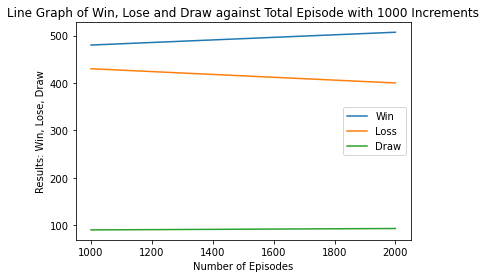

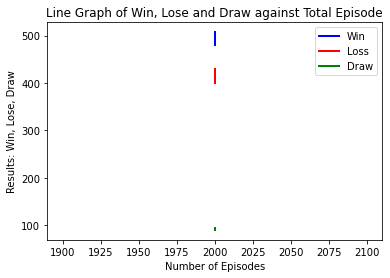

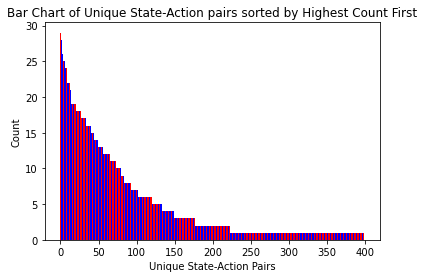


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'H'}, (13, 5): {0: 'H'}, (13, 6): {0: 'S'}, (13, 7): {0: 'H'}, (13, 8): {0: 'H'}, (13, 9): {0: 'S'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'H'}, (14, 5): {0: 'H'}, (14, 6): {0: 'H'}, (14, 7): {0: 'S'}, (14, 8): {0: 'H'}, (14, 9): {0: 'H'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'H'}, (15, 5): {0: 'H'}, (15, 6): {0: 'H'}, (15, 7): {0: 'H'}, (15, 8): {0: 'H'}, (15, 9): {0: 'H'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'H'}, (16, 5): {0: 'H'}, (16, 6): {0: 'S'}, (16, 7): {0: 'S'}, (16, 8): {0: 'H'}, (16, 9): {0: 'H'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'H'}, (17, 5): {0: 'S'}, (17, 6): {0: 

In [4]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 2000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique2 = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = False, e_config = 1)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
    print("\nN: ",N)
    print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique2 = num_unique2 + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique2 = num_unique2 + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique2)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
    if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
        for i in range(100): #to get the mean for last 100000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
    
        mean_win = mean_win/100000
        mean_loss = mean_loss/100000
        mean_draw = mean_draw/100000
    
#     if len(win) >= 2 and len(loss) >= 2 and len(draw)>= 2:
#         for i in range(2): #to get the mean for last 2000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
        
#         mean_win = mean_win/2000
#         mean_loss = mean_loss/2000
#         mean_draw = mean_draw/2000
    
    dealer_advantage_no_exploring_1 = ((mean_loss-mean_win)/(mean_loss+mean_win))
   

### Config 3: No Exploring States epsilon=e^(-k/1000)

Game Starting 


Your hand is:
J of Spades
3 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Dealer Hit
4 of Clubs
Q of Clubs
8 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Diamonds
2 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Dealer Hit
6 of Diamonds
J of Diamonds
K of Clubs
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Spades
10 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
Q of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
9 of Hearts 
K of Spades
Value: 19

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Diamonds
Q of Spades
Value: 21

Dealer's hand is: 
Hidden
Q of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
2 of Clubs
7 of Spades
Value: 9

Dealer's ha



Your hand is:
3 of Clubs
6 of Spades
Value: 9

Dealer's hand is: 
Hidden
K of Diamonds

Player Hit
3 of Clubs
6 of Spades
J of Hearts 
Value: 19

Your hand is:
3 of Clubs
6 of Spades
J of Hearts 
Value: 19

Dealer's hand is: 
Hidden
K of Diamonds

Player Hit
3 of Clubs
6 of Spades
J of Hearts 
6 of Clubs
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Spades
8 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
J of Spades
8 of Hearts 
7 of Spades
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Diamonds
3 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Final Results:
Player's hand: 13
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Hearts 
A of Diamonds
Value: 17

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
10 of Hearts 
2 of Clubs
6 of Diamonds
Value: 18

Final Results:
Player's hand: 17
Dealer's hand: 18

Dealer Wins!
Exited ga

Game Starting 


Your hand is:
A of Clubs
J of Spades
Value: 21

Dealer's hand is: 
Hidden
2 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
A of Spades
Value: 21

Dealer's hand is: 
Hidden
6 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
9 of Spades
Value: 15

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Final Results:
Player's hand: 15
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Dealer Hit
2 of Clubs
Q of Diamonds
3 of Clubs
Value: 15

Final Results:
Player's hand: 20
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
7 of Spades
Value: 15

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Final Results:
Player's hand: 15
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
9 of Spa

Game Starting 


Your hand is:
A of Hearts 
K of Clubs
Value: 21

Dealer's hand is: 
Hidden
5 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
6 of Clubs
J of Clubs
Value: 16

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
6 of Clubs
J of Clubs
9 of Spades
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Clubs
10 of Spades
Value: 13

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
3 of Clubs
10 of Spades
2 of Hearts 
Value: 15

Your hand is:
3 of Clubs
10 of Spades
2 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
3 of Clubs
10 of Spades
2 of Hearts 
4 of Diamonds
Value: 19

Your hand is:
3 of Clubs
10 of Spades
2 of Hearts 
4 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Hearts 
Q of Clubs
Value: 18

Dealer's hand is: 
Hidden
2 of Clubs

Player H

Game Starting 


Your hand is:
5 of Spades
8 of Spades
Value: 13

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
5 of Spades
8 of Spades
7 of Diamonds
Value: 20

Your hand is:
5 of Spades
8 of Spades
7 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
2 of Hearts 

Player Stand

Dealer Hit
K of Clubs
2 of Hearts 
4 of Hearts 
Value: 16

Final Results:
Player's hand: 20
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Diamonds
K of Spades
Value: 13

Dealer's hand is: 
Hidden
A of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
K of Clubs
6 of Hearts 
10 of Clubs
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
8 of Spades
Value: 11

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
3 of Hearts 
8 of Spades
5 of Clubs
Value: 16

Your hand is:
3 of Hearts 
8 of Spades
5 of Clubs
Value: 16

Deal

Game Starting 


Your hand is:
5 of Hearts 
A of Hearts 
Value: 16

Dealer's hand is: 
Hidden
K of Spades

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
5 of Spades
Value: 12

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
7 of Hearts 
5 of Spades
8 of Diamonds
Value: 20

Your hand is:
7 of Hearts 
5 of Spades
8 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Clubs
5 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Diamonds
4 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
6 of Diamonds

Player Hit
7 of Diamonds
4 of Diamonds
7 of Spades
Value: 18

Your hand is:
7 of Diamonds
4 of Diamonds
7 of Spades
Value: 18

Dealer's 

Game Starting 


Your hand is:
J of Clubs
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
7 of Diamonds

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 18

Tie!
Exited game
Game Starting 


Your hand is:
J of Hearts 
10 of Spades
Value: 20

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
J of Hearts 
10 of Spades
7 of Clubs
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Diamonds
3 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Dealer Hit
5 of Spades
9 of Clubs
3 of Hearts 
Value: 17

Final Results:
Player's hand: 14
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
7 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
2 of Diamonds
7 of Hearts 
7 of Diamonds
Value: 16

Your hand is:
2 of Diamonds
7 of Hearts 
7 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
2 of Diamonds
7 of Hearts 
7 of Diamonds
3 of Clubs
Value: 19

Your 

Game Starting 


Your hand is:
5 of Hearts 
10 of Clubs
Value: 15

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
5 of Hearts 
10 of Clubs
4 of Diamonds
Value: 19

Your hand is:
5 of Hearts 
10 of Clubs
4 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
5 of Hearts 
10 of Clubs
4 of Diamonds
A of Diamonds
Value: 20

Your hand is:
5 of Hearts 
10 of Clubs
4 of Diamonds
A of Diamonds
Value: 20

Dealer's hand is: 
Hidden
10 of Diamonds

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
8 of Clubs
Q of Spades
Value: 18

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand

Dealer Hit
3 of Spades
9 of Diamonds
4 of Clubs
Value: 16

Final Results:
Player's hand: 18
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Clubs
6 of Spades
Value: 9

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
3 of Clubs
6 of Spades
9 of Hearts 
Value: 18

Your hand is:
3 of Clubs
6 of 

Game Starting 


Your hand is:
8 of Spades
K of Spades
Value: 18

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
8 of Spades
K of Spades
K of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Clubs
4 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
5 of Hearts 

Player Stand

Dealer Hit
7 of Hearts 
5 of Hearts 
J of Diamonds
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
J of Diamonds
K of Spades
Value: 20

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
9 of Spades
4 of Spades
2 of Hearts 
Value: 15

Final Results:
Player's hand: 20
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Hearts 
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
J of Hearts 
8 of Spades
10 of Clubs
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Clubs
5 of Hearts 
Value: 10

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
5 of Clubs
5 of Hearts

Game Starting 


Your hand is:
10 of Hearts 
10 of Clubs
Value: 20

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
10 of Hearts 
10 of Clubs
9 of Clubs
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Diamonds
Q of Diamonds
Value: 17

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
7 of Diamonds
Q of Diamonds
8 of Diamonds
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Diamonds
8 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
Q of Hearts 

Player Stand

Dealer Hit
6 of Hearts 
Q of Hearts 
9 of Spades
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Clubs
10 of Hearts 
Value: 21

Dealer's hand is: 
Hidden
J of Spades
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
8 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
5 of Hearts 

Player Hit
Q of Hearts 
8 of Diamonds
J of Clubs
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of

Game Starting 


Your hand is:
3 of Clubs
10 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
3 of Clubs
10 of Hearts 
8 of Clubs
Value: 21

Your hand is:
3 of Clubs
10 of Hearts 
8 of Clubs
Value: 21

Dealer's hand is: 
Hidden
4 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
3 of Diamonds
8 of Clubs
Value: 11

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
3 of Diamonds
8 of Clubs
7 of Diamonds
Value: 18

Your hand is:
3 of Diamonds
8 of Clubs
7 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
5 of Diamonds
2 of Diamonds
10 of Hearts 
Value: 17

Final Results:
Player's hand: 18
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Hearts 
2 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
J of Hearts 
2 of Diamonds
5 of Hearts 
Value: 17

Your hand is:
J of Hearts 
2 of Diamonds
5 of Hearts 
Value: 17

Dealer's hand is: 
H

Game Starting 


Your hand is:
7 of Hearts 
A of Spades
Value: 18

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
7 of Hearts 
A of Spades
Q of Diamonds
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
7 of Spades
Value: 17

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
Q of Diamonds
4 of Spades
5 of Hearts 
Value: 19

Final Results:
Player's hand: 17
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
9 of Clubs
K of Diamonds
Value: 19

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
9 of Clubs
K of Diamonds
J of Spades
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Clubs
5 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
3 of Diamonds
5 of Spades
K of Clubs
Value: 18

Final Results:
Player's hand: 14
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
A of Hearts 
Value: 19

Dealer's hand is: 
Hidden
8

Game Starting 


Your hand is:
Q of Hearts 
Q of Clubs
Value: 20

Dealer's hand is: 
Hidden
3 of Hearts 

Player Stand

Dealer Hit
Q of Diamonds
3 of Hearts 
8 of Hearts 
Value: 21

Final Results:
Player's hand: 20
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Spades
7 of Spades
Value: 17

Dealer's hand is: 
Hidden
K of Spades

Player Hit
J of Spades
7 of Spades
5 of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Diamonds
6 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
5 of Diamonds
6 of Hearts 
K of Clubs
Value: 21

Your hand is:
5 of Diamonds
6 of Hearts 
K of Clubs
Value: 21

Dealer's hand is: 
Hidden
A of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
10 of Spades
9 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
Q of Spades

Player Stand

Dealer Hit
2 of Hearts 
Q of Spades
2 of Diamonds
Value: 14

Final Results:
Player's hand: 19
Dealer's ha

Game Starting 


Your hand is:
6 of Hearts 
J of Spades
Value: 16

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
K of Spades
2 of Diamonds
3 of Clubs
Value: 15

Final Results:
Player's hand: 16
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Clubs
2 of Clubs
Value: 13

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
A of Clubs
2 of Clubs
3 of Hearts 
Value: 16

Your hand is:
A of Clubs
2 of Clubs
3 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Hearts 
8 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
K of Hearts 
8 of Diamonds
Q of Clubs
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
Q of Clubs
Value: 13

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
3 of Hearts 
Q of Clubs
3 of Spades
Value: 16

Your hand is:
3 of Hearts 
Q 

Game Starting 


Your hand is:
8 of Clubs
K of Diamonds
Value: 18

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
3 of Diamonds
5 of Clubs
Value: 8

Dealer's hand is: 
Hidden
3 of Clubs

Player Hit
3 of Diamonds
5 of Clubs
9 of Diamonds
Value: 17

Your hand is:
3 of Diamonds
5 of Clubs
9 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
A of Diamonds
3 of Clubs
J of Spades
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Hearts 
9 of Clubs
Value: 19

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Dealer Hit
5 of Hearts 
K of Diamonds
7 of Spades
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Spades
7 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
3 of Hearts 

Player Hit
2 of Spades
7 of Hearts 
2 of Hearts 
Value: 11

Your hand is:
2 of Spades
7 of Hearts 
2 of Hearts 


Game Starting 


Your hand is:
J of Hearts 
10 of Clubs
Value: 20

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
J of Hearts 
10 of Clubs
8 of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
5 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
4 of Clubs
5 of Hearts 
J of Spades
Value: 19

Your hand is:
4 of Clubs
5 of Hearts 
J of Spades
Value: 19

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
Q of Clubs
2 of Diamonds
K of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Clubs
J of Clubs
Value: 15

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
5 of Diamonds
4 of Hearts 
7 of Hearts 
Value: 16

Final Results:
Player's hand: 15
Dealer's hand: 16

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Hearts 
K of Clubs
Value: 18

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
8 of Hearts 
K of Clubs
4 of Clubs
Value: 22

Player has lost

Game Starting 


Your hand is:
6 of Spades
9 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
6 of Spades
9 of Hearts 
7 of Hearts 
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
2 of Hearts 
Value: 6

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
4 of Clubs
2 of Hearts 
Q of Clubs
Value: 16

Your hand is:
4 of Clubs
2 of Hearts 
Q of Clubs
Value: 16

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Dealer Hit
4 of Diamonds
A of Diamonds
10 of Diamonds
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Spades
6 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
9 of Spades
6 of Hearts 
J of Hearts 
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Spades
K of Spades
Value: 12

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
2 of Spades
K of Spades
10 of Hearts 
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of 

Game Starting 


Your hand is:
9 of Clubs
4 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
9 of Clubs
4 of Hearts 
3 of Clubs
Value: 16

Your hand is:
9 of Clubs
4 of Hearts 
3 of Clubs
Value: 16

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
J of Hearts 
3 of Diamonds
4 of Spades
Value: 17

Final Results:
Player's hand: 16
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Hearts 
A of Spades
Value: 21

Dealer's hand is: 
Hidden
Q of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
8 of Clubs
Q of Diamonds
Value: 18

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
8 of Diamonds
5 of Spades
2 of Spades
Value: 15

Final Results:
Player's hand: 18
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
K of Spades
5 of Clubs
Value: 15

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
J of Spades
6 of Clubs
3 of Diamonds
Value: 

Game Starting 


Your hand is:
K of Hearts 
3 of Spades
Value: 13

Dealer's hand is: 
Hidden
3 of Clubs

Player Hit
K of Hearts 
3 of Spades
10 of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Spades
4 of Spades
Value: 13

Dealer's hand is: 
Hidden
3 of Hearts 

Player Stand

Dealer Hit
10 of Spades
3 of Hearts 
A of Clubs
Value: 14

Final Results:
Player's hand: 13
Dealer's hand: 14

Dealer Wins!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
7 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
8 of Hearts 
4 of Hearts 
2 of Clubs
Value: 14

Final Results:
Player's hand: 12
Dealer's hand: 14

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
K of Clubs
Q of Diamonds
9 of Spades
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Clubs
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
2 

Game Starting 


Your hand is:
3 of Hearts 
A of Spades
Value: 14

Dealer's hand is: 
Hidden
J of Spades

Player Hit
3 of Hearts 
A of Spades
2 of Diamonds
Value: 16

Your hand is:
3 of Hearts 
A of Spades
2 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
8 of Spades
Value: 10

Dealer's hand is: 
Hidden
K of Diamonds

Player Hit
2 of Diamonds
8 of Spades
7 of Hearts 
Value: 17

Your hand is:
2 of Diamonds
8 of Spades
7 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Dealer Hit
4 of Spades
K of Diamonds
3 of Clubs
Value: 17

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
A of Hearts 
9 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your 

Game Starting 


Your hand is:
K of Clubs
2 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
K of Clubs
2 of Diamonds
7 of Spades
Value: 19

Your hand is:
K of Clubs
2 of Diamonds
7 of Spades
Value: 19

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
Q of Diamonds
5 of Diamonds
10 of Clubs
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
4 of Hearts 
Value: 8

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
4 of Clubs
4 of Hearts 
7 of Hearts 
Value: 15

Your hand is:
4 of Clubs
4 of Hearts 
7 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
4 of Clubs
4 of Hearts 
7 of Hearts 
8 of Spades
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Hearts 
4 of Spades
Value: 11

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
7 of Hearts 
4 of Spades
5 of Clubs
Value: 16

Your hand is:
7 of Hearts 
4 of Spades
5 of Clubs
Value: 16

Dealer's hand is: 
Hidden
A 

Game Starting 


Your hand is:
2 of Clubs
A of Hearts 
Value: 13

Dealer's hand is: 
Hidden
K of Spades

Player Stand

Final Results:
Player's hand: 13
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A of Hearts 
9 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
3 of Clubs

Player Hit
A of Hearts 
9 of Diamonds
K of Diamonds
Value: 30

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Diamonds
2 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
7 of Diamonds
2 of Diamonds
5 of Clubs
Value: 14

Your hand is:
7 of Diamonds
2 of Diamonds
5 of Clubs
Value: 14

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
7 of Diamonds
2 of Diamonds
5 of Clubs
8 of Hearts 
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
10 of Spades
Value: 14

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
4 of Clubs
10 of Spades
A of Spades
Value: 15

Your hand is:
4 of Clubs
10 of Spades
A of Spades
Value: 15

Dealer

Game Starting 


Your hand is:
2 of Spades
6 of Diamonds
Value: 8

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
2 of Spades
6 of Diamonds
5 of Spades
Value: 13

Your hand is:
2 of Spades
6 of Diamonds
5 of Spades
Value: 13

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
2 of Spades
6 of Diamonds
5 of Spades
7 of Spades
Value: 20

Your hand is:
2 of Spades
6 of Diamonds
5 of Spades
7 of Spades
Value: 20

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Dealer Hit
7 of Diamonds
7 of Clubs
K of Diamonds
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
J of Diamonds
6 of Spades
Value: 16

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
J of Diamonds
6 of Spades
8 of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Spades
5 of Diamonds
Value: 10

Dealer's hand is: 
Hidden
2 of Spades

Player Hit
5 of Spades
5 of Diamonds
Q of Clubs
Value: 20

Your hand is:
5 of Spades
5 of Diamonds
Q of Clubs
Value: 20

Dealer's hand is: 

Game Starting 


Your hand is:
5 of Hearts 
Q of Spades
Value: 15

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Dealer Hit
4 of Clubs
Q of Clubs
8 of Diamonds
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
J of Spades
3 of Clubs
Value: 13

Dealer's hand is: 
Hidden
A of Hearts 

Player Stand

Dealer Hit
3 of Diamonds
A of Hearts 
6 of Diamonds
Value: 20

Final Results:
Player's hand: 13
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
9 of Clubs
K of Spades
Value: 19

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Clubs
Q of Spades
Value: 13

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Final Results:
Player's hand: 13
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
10 of Spades
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
10 of Spades
Q of Diamonds
2

Game Starting 


Your hand is:
Q of Diamonds
10 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Spades
6 of Clubs
Value: 9

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
3 of Spades
6 of Clubs
J of Hearts 
Value: 19

Your hand is:
3 of Spades
6 of Clubs
J of Hearts 
Value: 19

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
3 of Spades
6 of Clubs
J of Hearts 
6 of Spades
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
10 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
6 of Diamonds

Player Stand

Dealer Hit
J of Clubs
6 of Diamonds
K of Spades
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Diamonds
3 of Diamonds
Value: 7

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
4 of Diamonds
3 of Diamonds
K of Clubs
Value: 17

Your hand is:
4 of Diamonds
3 of Diamonds
K of Club

Game Starting 


Your hand is:
K of Diamonds
7 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
5 of Hearts 

Player Stand

Dealer Hit
2 of Hearts 
5 of Hearts 
3 of Clubs
Value: 10

Final Results:
Player's hand: 17
Dealer's hand: 10

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Spades
7 of Clubs
Value: 15

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
10 of Clubs
3 of Spades
7 of Hearts 
Value: 20

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
10 of Hearts 
2 of Clubs
Value: 12

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Final Results:
Player's hand: 12
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
9 of Diamonds
10 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
8 of Diamonds
3 of Diamonds
9 of Clubs
Value: 20

Final Results:
Player's hand: 19
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand

Game Starting 


Your hand is:
7 of Clubs
J of Spades
Value: 17

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
7 of Clubs
J of Spades
10 of Clubs
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Spades
J of Hearts 
Value: 16

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Dealer Hit
3 of Spades
10 of Hearts 
6 of Hearts 
Value: 19

Final Results:
Player's hand: 16
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
5 of Hearts 
Value: 7

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
2 of Diamonds
5 of Hearts 
5 of Diamonds
Value: 12

Your hand is:
2 of Diamonds
5 of Hearts 
5 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
10 of Diamonds
3 of Diamonds
3 of Clubs
Value: 16

Final Results:
Player's hand: 12
Dealer's hand: 16

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Spades
Q of Hearts 
Value: 18

Dealer's hand is: 
Hidden
7 of Hearts 

Player St

Game Starting 


Your hand is:
J of Spades
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
K of Diamonds
Value: 21

Dealer's hand is: 
Hidden
J of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
8 of Spades
9 of Spades
Value: 17

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Dealer Hit
6 of Clubs
7 of Hearts 
Q of Spades
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Hearts 
9 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
9 of Hearts 
9 of Diamonds
A of Diamonds
Value: 19

Your hand is:
9 of Hearts 
9 of Diamonds
A of Diamonds
Value: 19

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
9 of Hearts 
9 of Diamonds
A of Diamonds
4 of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Spades
5 of Spades

Game Starting 


Your hand is:
8 of Spades
10 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
A of Clubs
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
4 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
2 of Spades
8 of Diamonds
4 of Clubs
Value: 14

Final Results:
Player's hand: 14
Dealer's hand: 14

Tie!
Exited game
Game Starting 


Your hand is:
2 of Spades
7 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
2 of Spades
7 of Hearts 
K of Spades
Value: 19

Your hand is:
2 of Spades
7 of Hearts 
K of Spades
Value: 19

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Dealer Hit
6 of Diamonds
9 of Clubs
A of Hearts 
Value: 16

Final Results:
Player's hand: 19
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
2 of Clubs
Value: 9

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
7 of Spades
2 of Clubs
8 of Diamonds
Value: 17

Your hand is:
7 of Spad

Game Starting 


Your hand is:
5 of Hearts 
9 of Clubs
Value: 14

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
5 of Hearts 
9 of Clubs
2 of Clubs
Value: 16

Your hand is:
5 of Hearts 
9 of Clubs
2 of Clubs
Value: 16

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
5 of Hearts 
9 of Clubs
2 of Clubs
7 of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Hearts 
8 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
7 of Hearts 
8 of Diamonds
9 of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Hearts 
10 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
9 of Hearts 
10 of Hearts 
6 of Clubs
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Clubs
J of Hearts 
Value: 17

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
7 of Clubs
J of Hearts 
Q of Clubs
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Spades
Q of Spad

Game Starting 


Your hand is:
4 of Diamonds
4 of Clubs
Value: 8

Dealer's hand is: 
Hidden
3 of Hearts 

Player Hit
4 of Diamonds
4 of Clubs
J of Clubs
Value: 18

Your hand is:
4 of Diamonds
4 of Clubs
J of Clubs
Value: 18

Dealer's hand is: 
Hidden
3 of Hearts 

Player Stand

Dealer Hit
Q of Diamonds
3 of Hearts 
J of Spades
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
6 of Clubs
4 of Diamonds
Value: 10

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
6 of Clubs
4 of Diamonds
A of Hearts 
Value: 21

Your hand is:
6 of Clubs
4 of Diamonds
A of Hearts 
Value: 21

Dealer's hand is: 
Hidden
9 of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
9 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
2 of Spades

Player Hit
K of Clubs
9 of Diamonds
J of Spades
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Diamonds
9 of Clubs
Value: 15

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand



Game Starting 


Your hand is:
2 of Clubs
6 of Clubs
Value: 8

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
2 of Clubs
6 of Clubs
5 of Hearts 
Value: 13

Your hand is:
2 of Clubs
6 of Clubs
5 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
2 of Clubs
6 of Clubs
5 of Hearts 
3 of Clubs
Value: 16

Your hand is:
2 of Clubs
6 of Clubs
5 of Hearts 
3 of Clubs
Value: 16

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
2 of Clubs
6 of Clubs
5 of Hearts 
3 of Clubs
2 of Hearts 
Value: 18

Your hand is:
2 of Clubs
6 of Clubs
5 of Hearts 
3 of Clubs
2 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
10 of Spades
Value: 17

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
7 of Hearts 
10 of Spades
6 of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
4 of Spades
Valu

Game Starting 


Your hand is:
2 of Spades
K of Clubs
Value: 12

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
6 of Diamonds
3 of Clubs
8 of Hearts 
Value: 17

Final Results:
Player's hand: 12
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Hearts 
8 of Spades
Value: 12

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
4 of Hearts 
8 of Spades
6 of Hearts 
Value: 18

Your hand is:
4 of Hearts 
8 of Spades
6 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
4 of Hearts 
8 of Spades
6 of Hearts 
K of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Spades
10 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
2 of Diamonds
4 of Diamonds
9 of Spades
Value: 15

Final Results:
Player's hand: 17
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Diamonds
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
2 of Clubs

P

Game Starting 


Your hand is:
Q of Clubs
7 of Clubs
Value: 17

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
Q of Clubs
7 of Clubs
10 of Clubs
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Clubs
2 of Clubs
Value: 13

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
A of Clubs
2 of Clubs
Q of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Spades
J of Spades
Value: 20

Dealer's hand is: 
Hidden
4 of Clubs

Player Stand

Dealer Hit
K of Clubs
4 of Clubs
K of Hearts 
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
3 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
A of Clubs
3 of Diamonds
9 of Spades
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Diamonds
7 of Spades
Value: 18

Dealer's hand is: 
Hidden
6 of Diamonds

Player Stand

Dealer Hit
9 of Diamonds
6 of Diamonds
3 of Clubs
Value: 18

Final Results:
Pla



Your hand is:
6 of Hearts 
A of Spades
Value: 17

Dealer's hand is: 
Hidden
Q of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
A of Hearts 
Value: 17

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
6 of Spades
A of Hearts 
Q of Hearts 
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
6 of Spades
Value: 9

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
3 of Hearts 
6 of Spades
J of Clubs
Value: 19

Your hand is:
3 of Hearts 
6 of Spades
J of Clubs
Value: 19

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Dealer Hit
2 of Spades
10 of Hearts 
10 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Diamonds
4 of Spades
Value: 6

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
2 of Diamonds
4 of Spades
Q of Spades
Value: 16

Your hand is:
2 of Diamonds
4 of Spades
Q of Spades
Value: 16

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
2 of Diamo

Game Starting 


Your hand is:
6 of Clubs
Q of Spades
Value: 16

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Dealer Hit
2 of Diamonds
8 of Clubs
7 of Spades
Value: 17

Final Results:
Player's hand: 16
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Clubs
9 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
8 of Spades
4 of Hearts 
4 of Clubs
Value: 16

Final Results:
Player's hand: 19
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
4 of Spades
9 of Clubs
Value: 13

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
10 of Clubs
2 of Clubs
7 of Diamonds
Value: 19

Final Results:
Player's hand: 13
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
9 of Spades
6 of Clubs
Value: 15

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
9 of Spades
6 of Clubs
7 of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Clubs
2 o

Game Starting 


Your hand is:
8 of Hearts 
9 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
6 of Hearts 

Player Stand

Dealer Hit
J of Clubs
6 of Hearts 
9 of Spades
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Clubs
2 of Clubs
Value: 11

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
9 of Clubs
2 of Clubs
9 of Diamonds
Value: 20

Your hand is:
9 of Clubs
2 of Clubs
9 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
6 of Hearts 

Player Stand

Dealer Hit
10 of Spades
6 of Hearts 
3 of Diamonds
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
5 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
2 of Spades

Player Stand

Dealer Hit
9 of Clubs
2 of Spades
9 of Diamonds
Value: 20

Final Results:
Player's hand: 16
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Hearts 
K of Spades
Value: 20

Dealer's hand is: 
Hidden
A of Clubs

Player Stan

Game Starting 


Your hand is:
10 of Spades
7 of Clubs
Value: 17

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
10 of Spades
7 of Clubs
6 of Hearts 
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Spades
6 of Spades
Value: 14

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
8 of Spades
6 of Spades
9 of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Diamonds
A of Diamonds
Value: 20

Dealer's hand is: 
Hidden
K of Spades

Player Stand

Dealer Hit
2 of Diamonds
K of Spades
6 of Hearts 
Value: 18

Final Results:
Player's hand: 20
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
5 of Spades
A of Spades
Value: 16

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
5 of Spades
A of Spades
3 of Hearts 
Value: 19

Your hand is:
5 of Spades
A of Spades
3 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Dealer Hit
6 of Clubs
7 of Spades
2 of Clubs
Value: 15

Final Results:
P

Game Starting 


Your hand is:
6 of Clubs
A of Spades
Value: 17

Dealer's hand is: 
Hidden
A of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
5 of Hearts 
Value: 7

Dealer's hand is: 
Hidden
A of Spades
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
J of Spades
Value: 20

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
Q of Hearts 
J of Spades
9 of Diamonds
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Hearts 
8 of Clubs
Value: 18

Dealer's hand is: 
Hidden
A of Clubs
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
A of Diamonds
Q of Clubs
Value: 21

Dealer's hand is: 
Hidden
8 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
3 of Clubs
Value: 13

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
Q of Spades
3 of Clubs
Q of Diamonds
Value: 23

Player has lost !
Exited game
Gam

Game Starting 


Your hand is:
7 of Diamonds
6 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
7 of Diamonds
6 of Hearts 
K of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Spades
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
6 of Diamonds

Player Stand

Dealer Hit
9 of Clubs
6 of Diamonds
5 of Hearts 
Value: 20

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
9 of Hearts 
A of Hearts 
Value: 20

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
Q of Clubs
4 of Hearts 
J of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Hearts 
6 of Diamonds
Value: 10

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
4 of Hearts 
6 of Diamonds
J of Clubs
Value: 20

Your hand is:
4 of Hearts 
6 of Diamonds
J of Clubs
Value: 20

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Dealer Hit
5 of Spades
6 of Spades
A of Diamonds
Val

Game Starting 


Your hand is:
Q of Hearts 
K of Spades
Value: 20

Dealer's hand is: 
Hidden
K of Hearts 

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
4 of Clubs
K of Spades
Value: 14

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
4 of Clubs
K of Spades
Q of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Diamonds
7 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
3 of Diamonds
2 of Spades
Value: 5

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
3 of Diamonds
2 of Spades
7 of Hearts 
Value: 12

Your hand is:
3 of Diamonds
2 of Spades
7 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
3 of Diamonds
2 of Spades
7 of Hearts 
5 of Spades
Value: 17

Your hand is:
3 of Diamonds
2 of Spades
7 of Hearts 
5 of Spades
Value: 17

D

Game Starting 


Your hand is:
4 of Clubs
2 of Hearts 
Value: 6

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
4 of Clubs
2 of Hearts 
A of Hearts 
Value: 17

Your hand is:
4 of Clubs
2 of Hearts 
A of Hearts 
Value: 17

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
4 of Clubs
2 of Hearts 
A of Hearts 
7 of Hearts 
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Spades
2 of Hearts 
Value: 4

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
2 of Spades
2 of Hearts 
A of Clubs
Value: 15

Your hand is:
2 of Spades
2 of Hearts 
A of Clubs
Value: 15

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
2 of Spades
2 of Hearts 
A of Clubs
6 of Clubs
Value: 21

Your hand is:
2 of Spades
2 of Hearts 
A of Clubs
6 of Clubs
Value: 21

Dealer's hand is: 
Hidden
6 of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
J of Spades
Value: 17

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
7 of Spades
J of Spades

Game Starting 


Your hand is:
3 of Spades
10 of Spades
Value: 13

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
3 of Spades
10 of Spades
8 of Spades
Value: 21

Your hand is:
3 of Spades
10 of Spades
8 of Spades
Value: 21

Dealer's hand is: 
Hidden
K of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
K of Spades
J of Clubs
Value: 20

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
5 of Spades
6 of Clubs
2 of Clubs
Value: 13

Final Results:
Player's hand: 20
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
6 of Clubs
4 of Hearts 
Value: 10

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
6 of Clubs
4 of Hearts 
2 of Clubs
Value: 12

Your hand is:
6 of Clubs
4 of Hearts 
2 of Clubs
Value: 12

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Dealer Hit
3 of Clubs
9 of Clubs
J of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
J of Hearts 
Q of Spades
Value: 20

Dealer's ha

Game Starting 


Your hand is:
9 of Diamonds
8 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
6 of Hearts 

Player Stand

Dealer Hit
6 of Diamonds
6 of Hearts 
9 of Hearts 
Value: 21

Final Results:
Player's hand: 17
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Diamonds
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
Q of Diamonds
6 of Hearts 
2 of Hearts 
Value: 18

Your hand is:
Q of Diamonds
6 of Hearts 
2 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
Q of Diamonds
6 of Hearts 
2 of Hearts 
J of Spades
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Hearts 
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
Q of Hearts 
J of Diamonds
8 of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Diamonds
Q of Spades
Value: 17

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
7 of Diamonds
Q of Spades
K of Spades
Va

Game Starting 


Your hand is:
3 of Diamonds
A of Hearts 
Value: 14

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
5 of Spades
5 of Clubs
Value: 10

Dealer's hand is: 
Hidden
5 of Hearts 

Player Hit
5 of Spades
5 of Clubs
2 of Diamonds
Value: 12

Your hand is:
5 of Spades
5 of Clubs
2 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
5 of Hearts 

Player Stand

Dealer Hit
6 of Spades
5 of Hearts 
7 of Hearts 
Value: 18

Final Results:
Player's hand: 12
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
2 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
7 of Spades
2 of Hearts 
9 of Spades
Value: 18

Your hand is:
7 of Spades
2 of Hearts 
9 of Spades
Value: 18

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
7 of Spades
2 of Hearts 
9 of Spades
6 of Hearts 
Value: 24

Player has lost !
Exited game
Game Starting 


Yo

Game Starting 


Your hand is:
10 of Spades
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand

Dealer Hit
7 of Clubs
9 of Diamonds
2 of Hearts 
Value: 18

Final Results:
Player's hand: 20
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
4 of Hearts 
A of Diamonds
Value: 15

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
10 of Spades
Value: 20

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Dealer Hit
2 of Spades
Q of Clubs
6 of Hearts 
Value: 18

Final Results:
Player's hand: 20
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
4 of Spades
J of Diamonds
Value: 14

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Hearts 
8 of Spades
Value: 18

Dealer's hand is: 


Game Starting 


Your hand is:
8 of Spades
9 of Clubs
Value: 17

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Dealer Hit
10 of Diamonds
6 of Spades
6 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Hearts 
9 of Spades
Value: 11

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
2 of Hearts 
9 of Spades
8 of Spades
Value: 19

Your hand is:
2 of Hearts 
9 of Spades
8 of Spades
Value: 19

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
2 of Hearts 
9 of Spades
8 of Spades
9 of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Hearts 
5 of Spades
Value: 12

Dealer's hand is: 
Hidden
3 of Hearts 

Player Stand

Dealer Hit
6 of Clubs
3 of Hearts 
A of Clubs
Value: 20

Final Results:
Player's hand: 12
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Clubs
3 of Hearts 
Value: 5

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
2 of Clubs
3 of Hearts 
8 of Clubs
Value: 13

You

Game Starting 


Your hand is:
9 of Spades
J of Diamonds
Value: 19

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
K of Hearts 
3 of Diamonds
2 of Spades
Value: 15

Final Results:
Player's hand: 19
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Hearts 
10 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
8 of Hearts 
10 of Hearts 
4 of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Clubs
10 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
J of Diamonds
2 of Diamonds
7 of Hearts 
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
4 of Spades
Value: 14

Dealer's hand is: 
Hidden
A of Spades

Player Hit
Q of Spades
4 of Spades
2 of Diamonds
Value: 16

Your hand is:
Q of Spades
4 of Spades
2 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
A of Spades

Player 

Game Starting 


Your hand is:
A of Diamonds
6 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
A of Clubs
5 of Spades
9 of Spades
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
A of Diamonds
Value: 14

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Dealer Hit
2 of Spades
7 of Hearts 
9 of Hearts 
Value: 18

Final Results:
Player's hand: 14
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
9 of Clubs
5 of Clubs
Value: 14

Dealer's hand is: 
Hidden
K of Clubs

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
7 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
10 of Diamonds

Player Stand

Dealer Hit
2 of Clubs
10 of Diamonds
5 of Diamonds
Value: 17

Final Results:
Player's hand: 15
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
3 of Hearts 
6 of Spades
Value: 9

Dealer

Game Starting 


Your hand is:
3 of Hearts 
3 of Clubs
Value: 6

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
3 of Clubs
4 of Clubs
Value: 10

Your hand is:
3 of Hearts 
3 of Clubs
4 of Clubs
Value: 10

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
3 of Clubs
4 of Clubs
Q of Diamonds
Value: 20

Your hand is:
3 of Hearts 
3 of Clubs
4 of Clubs
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
7 of Diamonds
2 of Clubs
8 of Spades
Value: 17

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Diamonds
Q of Spades
Value: 20

Dealer's hand is: 
Hidden
2 of Hearts 

Player Stand

Dealer Hit
10 of Clubs
2 of Hearts 
K of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Hearts 
10 of Spades
Value: 20

Dealer's hand is: 
Hidden
A of Spades

Player Stand

Dealer Hit
A of Diamonds
A of Spades
J of Hearts 
Value: 22

Dealer has lost 

Game Starting 


Your hand is:
6 of Hearts 
7 of Spades
Value: 13

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
6 of Hearts 
7 of Spades
6 of Spades
Value: 19

Your hand is:
6 of Hearts 
7 of Spades
6 of Spades
Value: 19

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 19

Tie!
Exited game
Game Starting 


Your hand is:
K of Hearts 
Q of Spades
Value: 20

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
5 of Clubs
4 of Diamonds
J of Hearts 
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
2 of Spades
7 of Spades
Value: 9

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
2 of Spades
7 of Spades
3 of Diamonds
Value: 12

Your hand is:
2 of Spades
7 of Spades
3 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
2 of Spades
7 of Spades
3 of Diamonds
6 of Clubs
Value: 18

Your hand is:
2 of Spades
7 of Spades
3 of Diamonds
6 o

Game Starting 


Your hand is:
2 of Diamonds
4 of Clubs
Value: 6

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
2 of Diamonds
4 of Clubs
J of Spades
Value: 16

Your hand is:
2 of Diamonds
4 of Clubs
J of Spades
Value: 16

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
2 of Diamonds
4 of Clubs
J of Spades
10 of Spades
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Diamonds
5 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
Q of Spades

Player Hit
J of Diamonds
5 of Hearts 
J of Clubs
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Clubs
10 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
3 of Hearts 

Player Hit
7 of Clubs
10 of Diamonds
4 of Spades
Value: 21

Your hand is:
7 of Clubs
10 of Diamonds
4 of Spades
Value: 21

Dealer's hand is: 
Hidden
3 of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
3 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
5 of Diamonds

Player H

Game Starting 


Your hand is:
A of Diamonds
6 of Spades
Value: 17

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
A of Diamonds
6 of Spades
10 of Clubs
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Hearts 
K of Hearts 
Value: 12

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
2 of Hearts 
K of Hearts 
5 of Clubs
Value: 17

Your hand is:
2 of Hearts 
K of Hearts 
5 of Clubs
Value: 17

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
2 of Hearts 
K of Hearts 
5 of Clubs
A of Diamonds
Value: 18

Your hand is:
2 of Hearts 
K of Hearts 
5 of Clubs
A of Diamonds
Value: 18

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
2 of Hearts 
K of Hearts 
5 of Clubs
A of Diamonds
J of Clubs
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Spades
2 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
10 of Spades
2 of Hearts 
7 of Hearts 
Value: 19

Your hand is:
10 of Spades
2 of Hearts 
7 of Hearts 
Value: 19

Game Starting 


Your hand is:
J of Spades
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
9 of Spades

Player Stand

Dealer Hit
5 of Clubs
9 of Spades
2 of Hearts 
Value: 16

Final Results:
Player's hand: 20
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Diamonds
9 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
K of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
K of Spades
Value: 20

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
6 of Diamonds
5 of Diamonds
K of Diamonds
Value: 21

Final Results:
Player's hand: 20
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Diamonds
J of Clubs
Value: 21

Dealer's hand is: 
Hidden
J of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
7 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Dealer Hit
9 of Spades
7 of Clubs
2 of Spades
Value: 1

Game Starting 


Your hand is:
5 of Spades
6 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
5 of Spades
6 of Hearts 
6 of Diamonds
Value: 17

Your hand is:
5 of Spades
6 of Hearts 
6 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Dealer Hit
9 of Clubs
7 of Clubs
Q of Spades
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Hearts 
A of Spades
Value: 21

Dealer's hand is: 
Hidden
3 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
10 of Clubs
9 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
8 of Hearts 

Player Stand

Dealer Hit
7 of Diamonds
8 of Hearts 
K of Diamonds
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
3 of Clubs
Value: 13

Dealer's hand is: 
Hidden
8 of Diamonds

Player Hit
K of Spades
3 of Clubs
8 of Spades
Value: 21

Your hand is:
K of Spades
3 of Clubs
8 of Spades
Value: 21

Dealer's hand is: 
Hidden
8 of Diamonds


Game Starting 


Your hand is:
J of Diamonds
5 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
8 of Hearts 

Player Stand

Dealer Hit
3 of Spades
8 of Hearts 
J of Spades
Value: 21

Final Results:
Player's hand: 15
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
K of Hearts 
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
7 of Diamonds

Player Stand

Dealer Hit
3 of Spades
7 of Diamonds
6 of Spades
Value: 16

Final Results:
Player's hand: 20
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
7 of Spades
Value: 15

Dealer's hand is: 
Hidden
K of Clubs

Player Stand

Dealer Hit
3 of Clubs
K of Clubs
4 of Hearts 
Value: 17

Final Results:
Player's hand: 15
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
8 of Clubs
Value: 10

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
2 of Diamonds
8 of Clubs
J of Diamonds
Value: 20

Your hand is:
2 of Diamonds
8 of Clubs
J of Diamonds
Va

Game Starting 


Your hand is:
10 of Hearts 
2 of Spades
Value: 12

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Dealer Hit
2 of Diamonds
J of Spades
A of Spades
Value: 13

Final Results:
Player's hand: 12
Dealer's hand: 13

Dealer Wins!
Exited game
Game Starting 


Your hand is:
3 of Clubs
6 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
3 of Clubs
6 of Hearts 
2 of Spades
Value: 11

Your hand is:
3 of Clubs
6 of Hearts 
2 of Spades
Value: 11

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
3 of Clubs
6 of Hearts 
2 of Spades
6 of Spades
Value: 17

Your hand is:
3 of Clubs
6 of Hearts 
2 of Spades
6 of Spades
Value: 17

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Dealer Hit
3 of Diamonds
9 of Hearts 
10 of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Spades
8 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
10 of Spades
8 of Diamonds
7 of Clubs
Value: 25

Player has lost !
E

Game Starting 


Your hand is:
7 of Clubs
A of Hearts 
Value: 18

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
7 of Clubs
A of Hearts 
9 of Spades
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
Q of Diamonds
Value: 21

Dealer's hand is: 
Hidden
5 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
3 of Clubs
2 of Spades
Value: 5

Dealer's hand is: 
Hidden
8 of Clubs

Player Hit
3 of Clubs
2 of Spades
4 of Diamonds
Value: 9

Your hand is:
3 of Clubs
2 of Spades
4 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
8 of Clubs

Player Hit
3 of Clubs
2 of Spades
4 of Diamonds
3 of Diamonds
Value: 12

Your hand is:
3 of Clubs
2 of Spades
4 of Diamonds
3 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Dealer Hit
6 of Diamonds
8 of Clubs
J of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
J of Diamonds
Value: 14

Dealer's hand is: 
Hidden
8 of Hearts 

Game Starting 


Your hand is:
3 of Hearts 
10 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
3 of Hearts 
10 of Hearts 
K of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Diamonds
6 of Clubs
Value: 13

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
7 of Diamonds
6 of Clubs
4 of Clubs
Value: 17

Your hand is:
7 of Diamonds
6 of Clubs
4 of Clubs
Value: 17

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
5 of Clubs
7 of Clubs
Value: 12

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
A of Hearts 
4 of Diamonds
2 of Spades
Value: 17

Final Results:
Player's hand: 12
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
2 of Spades
Value: 12

Dealer's hand is: 
Hidden
5 of Hearts 

Player Stand

Dealer Hit
K of Spades
5 of Hearts 
10 of Clubs
Value: 25

Dealer has los

Game Starting 


Your hand is:
4 of Hearts 
5 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
4 of Hearts 
5 of Diamonds
5 of Spades
Value: 14

Your hand is:
4 of Hearts 
5 of Diamonds
5 of Spades
Value: 14

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
4 of Hearts 
5 of Diamonds
5 of Spades
3 of Spades
Value: 17

Your hand is:
4 of Hearts 
5 of Diamonds
5 of Spades
3 of Spades
Value: 17

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
7 of Spades
4 of Spades
6 of Diamonds
Value: 17

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
Q of Spades
A of Hearts 
Value: 21

Dealer's hand is: 
Hidden
4 of Spades
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
A of Hearts 
Value: 17

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
6 of Spades
A of Hearts 
3 of Hearts 
Value: 20

Your hand is:
6 of Spades
A of Hearts 
3 of Hearts 
Value: 20

Dealer's hand is

Game Starting 


Your hand is:
9 of Hearts 
9 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
9 of Hearts 
9 of Diamonds
4 of Hearts 
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Spades
9 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
J of Spades

Player Hit
Q of Spades
9 of Hearts 
10 of Clubs
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Spades
6 of Spades
Value: 16

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Dealer Hit
3 of Diamonds
8 of Clubs
7 of Diamonds
Value: 18

Final Results:
Player's hand: 16
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
9 of Clubs
Value: 17

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
6 of Hearts 
10 of Clubs
2 of Spades
Value: 18

Final Results:
Player's hand: 17
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A of Diamonds
10 of Spades
Value: 21

Dealer's hand is: 
Hid

Game Starting 


Your hand is:
10 of Diamonds
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
K of Spades

Player Stand

Dealer Hit
6 of Spades
K of Spades
A of Hearts 
Value: 17

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
3 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
K of Spades

Player Stand

Dealer Hit
3 of Clubs
K of Spades
4 of Spades
Value: 17

Final Results:
Player's hand: 13
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
2 of Hearts 
Value: 10

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
8 of Diamonds
2 of Hearts 
Q of Hearts 
Value: 20

Your hand is:
8 of Diamonds
2 of Hearts 
Q of Hearts 
Value: 20

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
K of Diamonds
3 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand





Your hand is:
3 of Hearts 
A of Hearts 
Value: 14

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Dealer Hit
5 of Spades
10 of Hearts 
9 of Spades
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Clubs
Q of Hearts 
Value: 20

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
10 of Clubs
Q of Hearts 
9 of Clubs
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Hearts 
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
J of Hearts 
6 of Hearts 
J of Clubs
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Hearts 
3 of Clubs
Value: 9

Dealer's hand is: 
Hidden
K of Spades
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
J of Spades
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Dealer Hit
A of Hearts 
A of Diamonds
5 of Spades
Value: 17

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
G

Game Starting 


Your hand is:
2 of Clubs
7 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
2 of Clubs
7 of Diamonds
6 of Clubs
Value: 15

Your hand is:
2 of Clubs
7 of Diamonds
6 of Clubs
Value: 15

Dealer's hand is: 
Hidden
3 of Spades

Player Stand

Dealer Hit
9 of Spades
3 of Spades
5 of Spades
Value: 17

Final Results:
Player's hand: 15
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Hearts 
7 of Spades
Value: 15

Dealer's hand is: 
Hidden
8 of Spades

Player Hit
8 of Hearts 
7 of Spades
9 of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Clubs
5 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
6 of Clubs
5 of Hearts 
J of Diamonds
Value: 21

Your hand is:
6 of Clubs
5 of Hearts 
J of Diamonds
Value: 21

Dealer's hand is: 
Hidden
2 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
A of Hearts 
3 of Diamonds
Value: 14

Dealer's hand 



Your hand is:
2 of Diamonds
10 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
7 of Diamonds
8 of Diamonds
10 of Spades
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Hearts 
3 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
2 of Diamonds
6 of Clubs
Q of Spades
Value: 18

Final Results:
Player's hand: 13
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Spades
A of Diamonds
Value: 17

Dealer's hand is: 
Hidden
2 of Hearts 

Player Stand

Dealer Hit
6 of Diamonds
2 of Hearts 
10 of Diamonds
Value: 18

Final Results:
Player's hand: 17
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
J of Hearts 
Q of Hearts 
Value: 20

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
J of Diamonds
4 of Diamonds
Value: 14

Dealer's hand is

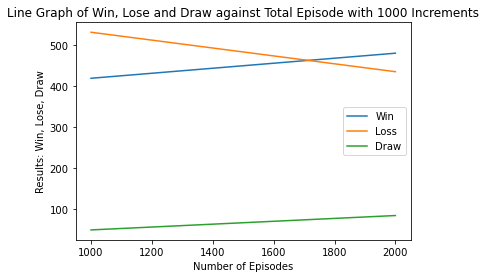

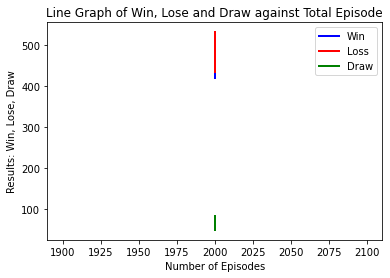

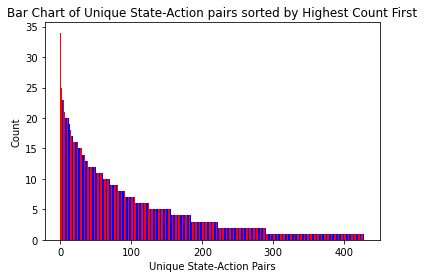


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'H'}, (13, 5): {0: 'H'}, (13, 6): {0: 'H'}, (13, 7): {0: 'H'}, (13, 8): {0: 'H'}, (13, 9): {0: 'S'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'H'}, (14, 5): {0: 'H'}, (14, 6): {0: 'H'}, (14, 7): {0: 'H'}, (14, 8): {0: 'H'}, (14, 9): {0: 'H'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'H'}, (15, 5): {0: 'S'}, (15, 6): {0: 'H'}, (15, 7): {0: 'H'}, (15, 8): {0: 'H'}, (15, 9): {0: 'H'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'H'}, (16, 5): {0: 'H'}, (16, 6): {0: 'S'}, (16, 7): {0: 'H'}, (16, 8): {0: 'H'}, (16, 9): {0: 'S'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'H'}, (17, 5): {0: 'H'}, (17, 6): {0: 

In [5]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 2000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique3 = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = False, e_config = 2)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
    print("\nN: ",N)
    print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique3 = num_unique3 + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique3 = num_unique3 + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique3)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
    if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
        for i in range(100): #to get the mean for last 100000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
    
        mean_win = mean_win/100000
        mean_loss = mean_loss/100000
        mean_draw = mean_draw/100000
    
#     if len(win) >= 2 and len(loss) >= 2 and len(draw)>= 2:
#         for i in range(2): #to get the mean for last 2000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
        
#         mean_win = mean_win/2000
#         mean_loss = mean_loss/2000
#         mean_draw = mean_draw/2000
    
    dealer_advantage_no_exploring_2 = ((mean_loss-mean_win)/(mean_loss+mean_win))

### Config 4: No Exploring States epsilon=e^(-k/10000)

Game Starting 


Your hand is:
5 of Diamonds
A of Clubs
Value: 16

Dealer's hand is: 
Hidden
8 of Spades

Player Hit
5 of Diamonds
A of Clubs
3 of Spades
Value: 19

Your hand is:
5 of Diamonds
A of Clubs
3 of Spades
Value: 19

Dealer's hand is: 
Hidden
8 of Spades

Player Hit
5 of Diamonds
A of Clubs
3 of Spades
6 of Diamonds
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
7 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
3 of Hearts 

Player Hit
K of Spades
7 of Hearts 
8 of Hearts 
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Clubs
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
J of Spades

Player Hit
Q of Clubs
K of Hearts 
4 of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Clubs
8 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Dealer Hit
2 of Hearts 
Q of Diamonds
Q of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is

Game Starting 


Your hand is:
J of Spades
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
5 of Hearts 
8 of Diamonds
J of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Hearts 
2 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
Q of Hearts 
2 of Diamonds
10 of Hearts 
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Spades
3 of Spades
Value: 12

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
9 of Spades
3 of Spades
5 of Diamonds
Value: 17

Your hand is:
9 of Spades
3 of Spades
5 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
2 of Hearts 

Player Stand

Dealer Hit
3 of Clubs
2 of Hearts 
9 of Hearts 
Value: 14

Final Results:
Player's hand: 17
Dealer's hand: 14

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Hearts 
3 of Clubs
Value: 10

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
7 of Hearts 
3 of Clubs
6 of Spades
Value: 16

Yo

Game Starting 


Your hand is:
5 of Hearts 
6 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
5 of Hearts 
6 of Hearts 
8 of Spades
Value: 19

Your hand is:
5 of Hearts 
6 of Hearts 
8 of Spades
Value: 19

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
5 of Hearts 
6 of Hearts 
8 of Spades
8 of Hearts 
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Spades
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
K of Spades

Player Hit
10 of Spades
K of Hearts 
5 of Clubs
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Diamonds
5 of Diamonds
Value: 7

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
2 of Diamonds
5 of Diamonds
4 of Clubs
Value: 11

Your hand is:
2 of Diamonds
5 of Diamonds
4 of Clubs
Value: 11

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
2 of Diamonds
5 of Diamonds
4 of Clubs
A of Diamonds
Value: 12

Your hand is:
2 of Diamonds
5 of Diamonds
4 of Clubs
A of Diamonds
Value: 12

Dea

Game Starting 


Your hand is:
8 of Diamonds
A of Clubs
Value: 19

Dealer's hand is: 
Hidden
2 of Spades

Player Hit
8 of Diamonds
A of Clubs
K of Diamonds
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Clubs
J of Spades
Value: 20

Dealer's hand is: 
Hidden
10 of Spades

Player Stand

Dealer Hit
3 of Hearts 
10 of Spades
J of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
7 of Diamonds
J of Diamonds
Value: 17

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
Q of Spades
5 of Diamonds
6 of Clubs
Value: 21

Final Results:
Player's hand: 17
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
6 of Clubs
4 of Spades
Value: 10

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
6 of Clubs
4 of Spades
8 of Spades
Value: 18

Your hand is:
6 of Clubs
4 of Spades
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 20

Dealer W

Game Starting 


Your hand is:
K of Clubs
3 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
3 of Hearts 

Player Stand

Dealer Hit
9 of Hearts 
3 of Hearts 
4 of Clubs
Value: 16

Final Results:
Player's hand: 13
Dealer's hand: 16

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Spades
Q of Diamonds
Value: 14

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
4 of Spades
Q of Diamonds
A of Diamonds
Value: 15

Your hand is:
4 of Spades
Q of Diamonds
A of Diamonds
Value: 15

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
4 of Spades
Q of Diamonds
A of Diamonds
10 of Spades
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Spades
10 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
8 of Spades
10 of Diamonds
2 of Diamonds
Value: 20

Your hand is:
8 of Spades
10 of Diamonds
2 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
8 of Spades
10 of Diamonds
2 of Diamonds
10 of Spades
Value: 30

Player ha

Game Starting 


Your hand is:
8 of Diamonds
Q of Hearts 
Value: 18

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Dealer Hit
3 of Diamonds
Q of Diamonds
3 of Clubs
Value: 16

Final Results:
Player's hand: 18
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
7 of Clubs
Value: 17

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
K of Clubs
7 of Clubs
9 of Diamonds
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Clubs
5 of Clubs
Value: 11

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
6 of Clubs
5 of Clubs
Q of Clubs
Value: 21

Your hand is:
6 of Clubs
5 of Clubs
Q of Clubs
Value: 21

Dealer's hand is: 
Hidden
J of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Diamonds
4 of Clubs
Value: 14

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
Q of Diamonds
4 of Clubs
4 of Diamonds
Value: 18

Your hand is:
Q of Diamonds
4 of Clubs
4 of Diamonds
Value: 18

Dealer's hand 

Game Starting 


Your hand is:
6 of Diamonds
8 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
6 of Diamonds
8 of Diamonds
J of Spades
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
8 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
8 of Hearts 
9 of Hearts 
Value: 20

Your hand is:
3 of Hearts 
8 of Hearts 
9 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
10 of Clubs
2 of Clubs
Q of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Hearts 
7 of Spades
Value: 17

Dealer's hand is: 
Hidden
10 of Clubs

Player Hit
10 of Hearts 
7 of Spades
2 of Spades
Value: 19

Your hand is:
10 of Hearts 
7 of Spades
2 of Spades
Value: 19

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 19

Tie!
Exited game
Game Starting 


Your hand is:
K of Spades
8 of Hearts 
Value: 18

Dealer's

Game Starting 


Your hand is:
6 of Spades
3 of Spades
Value: 9

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
6 of Spades
3 of Spades
J of Spades
Value: 19

Your hand is:
6 of Spades
3 of Spades
J of Spades
Value: 19

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
6 of Spades
3 of Spades
J of Spades
9 of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Diamonds
2 of Spades
Value: 12

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
Q of Diamonds
2 of Spades
K of Spades
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Clubs
J of Hearts 
Value: 13

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
3 of Clubs
J of Hearts 
K of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
2 of Clubs
Value: 12

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
6 of Diamonds
5 of Diamonds
5 of Hearts 
Value: 16

Final Results:
Player's hand: 12
Dealer's hand: 16

Deal

Game Starting 


Your hand is:
2 of Hearts 
2 of Spades
Value: 4

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
2 of Hearts 
2 of Spades
4 of Spades
Value: 8

Your hand is:
2 of Hearts 
2 of Spades
4 of Spades
Value: 8

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
2 of Hearts 
2 of Spades
4 of Spades
8 of Diamonds
Value: 16

Your hand is:
2 of Hearts 
2 of Spades
4 of Spades
8 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
K of Clubs

Player Hit
2 of Hearts 
2 of Spades
4 of Spades
8 of Diamonds
J of Diamonds
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
J of Hearts 
Value: 14

Dealer's hand is: 
Hidden
K of Hearts 

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Diamonds
7 of Spades
Value: 14

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
7 of Diamonds
7 of Spades
7 of Clubs
Value: 21

Your hand is:
7 of Diamonds
7 of Spades
7 of Clubs
Value: 21

Dealer'

Game Starting 


Your hand is:
5 of Diamonds
K of Diamonds
Value: 15

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
7 of Diamonds
4 of Spades
8 of Clubs
Value: 19

Final Results:
Player's hand: 15
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Hearts 
2 of Clubs
Value: 8

Dealer's hand is: 
Hidden
J of Clubs

Player Hit
6 of Hearts 
2 of Clubs
Q of Hearts 
Value: 18

Your hand is:
6 of Hearts 
2 of Clubs
Q of Hearts 
Value: 18

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Dealer Hit
4 of Spades
J of Clubs
K of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Diamonds
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
4 of Spades
3 of Hearts 
Value: 7

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
4 of Spades
3 of Hearts 
9 of Hearts 
Value: 16

Your hand is:

Game Starting 


Your hand is:
J of Diamonds
Q of Spades
Value: 20

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
Q of Diamonds
5 of Spades
7 of Spades
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
6 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
K of Diamonds
6 of Diamonds
7 of Hearts 
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Hearts 
Q of Clubs
Value: 20

Dealer's hand is: 
Hidden
A of Spades
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
9 of Hearts 
Q of Spades
Value: 19

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 19

Tie!
Exited game
Game Starting 


Your hand is:
5 of Spades
10 of Spades
Value: 15

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Dealer Hit
2 of Clubs
Q of Diamonds
4 of Hearts 
Value: 16

Final Results:
Player's hand: 15
Dealer's hand: 16

Dealer Wins

Game Starting 


Your hand is:
7 of Hearts 
6 of Spades
Value: 13

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Dealer Hit
6 of Diamonds
7 of Spades
10 of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Clubs
J of Hearts 
Value: 20

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Dealer Hit
6 of Hearts 
Q of Diamonds
8 of Spades
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
J of Spades
Q of Spades
Value: 20

Dealer's hand is: 
Hidden
8 of Spades

Player Stand

Dealer Hit
8 of Clubs
8 of Spades
A of Hearts 
Value: 17

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
Q of Hearts 
8 of Spades
5 of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Clubs
9 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
K of Spades

Player Hit
5 of Club

Game Starting 


Your hand is:
8 of Hearts 
Q of Clubs
Value: 18

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Dealer Hit
2 of Hearts 
K of Diamonds
10 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Hearts 
2 of Hearts 
Value: 7

Dealer's hand is: 
Hidden
A of Hearts 

Player Hit
5 of Hearts 
2 of Hearts 
10 of Hearts 
Value: 17

Your hand is:
5 of Hearts 
2 of Hearts 
10 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
A of Hearts 

Player Stand

Dealer Hit
4 of Hearts 
A of Hearts 
9 of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
J of Spades
Value: 21

Dealer's hand is: 
Hidden
A of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
7 of Clubs
4 of Clubs
Value: 11

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
7 of Clubs
4 of Clubs
K of Diamonds
Value: 21

Your hand is:
7 of Clubs
4 of Clubs
K of Diamonds
Value: 21

Dealer's hand is: 
Hidden
5 of Diam

Game Starting 


Your hand is:
9 of Spades
9 of Clubs
Value: 18

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
A of Clubs
3 of Diamonds
2 of Spades
Value: 16

Final Results:
Player's hand: 18
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
K of Clubs
Value: 16

Dealer's hand is: 
Hidden
7 of Spades

Player Hit
6 of Diamonds
K of Clubs
J of Hearts 
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Diamonds
3 of Hearts 
Value: 8

Dealer's hand is: 
Hidden
J of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
7 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
5 of Diamonds
7 of Hearts 
2 of Clubs
Value: 14

Your hand is:
5 of Diamonds
7 of Hearts 
2 of Clubs
Value: 14

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
5 of Diamonds
7 of Hearts 
2 of Clubs
6 of Diamonds
Value: 20

Your hand is:
5 of Diamonds
7 of Hearts 
2 of

Game Starting 


Your hand is:
4 of Clubs
9 of Spades
Value: 13

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Final Results:
Player's hand: 13
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Diamonds
J of Spades
Value: 14

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
4 of Diamonds
J of Spades
4 of Hearts 
Value: 18

Your hand is:
4 of Diamonds
J of Spades
4 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
4 of Diamonds
J of Spades
4 of Hearts 
3 of Clubs
Value: 21

Your hand is:
4 of Diamonds
J of Spades
4 of Hearts 
3 of Clubs
Value: 21

Dealer's hand is: 
Hidden
7 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
J of Spades
6 of Spades
Value: 16

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
J of Spades
6 of Spades
Q of Hearts 
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Spades
J of Clubs
Value: 16

Dealer's hand is: 
Hidden
8 of Spades

Pla

Game Starting 


Your hand is:
3 of Spades
7 of Diamonds
Value: 10

Dealer's hand is: 
Hidden
6 of Clubs

Player Hit
3 of Spades
7 of Diamonds
Q of Spades
Value: 20

Your hand is:
3 of Spades
7 of Diamonds
Q of Spades
Value: 20

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
6 of Spades
6 of Clubs
3 of Diamonds
Value: 15

Final Results:
Player's hand: 20
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
8 of Spades
Value: 19

Dealer's hand is: 
Hidden
5 of Hearts 

Player Stand

Dealer Hit
10 of Spades
5 of Hearts 
10 of Clubs
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
K of Spades
Value: 13

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
3 of Hearts 
K of Spades
K of Hearts 
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Hearts 
3 of Diamonds
Value: 7

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
4 of Hearts 
3 of Diamonds
6 of Clubs
Value: 13

Your han

Game Starting 


Your hand is:
7 of Hearts 
2 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
7 of Hearts 
2 of Hearts 
K of Spades
Value: 19

Your hand is:
7 of Hearts 
2 of Hearts 
K of Spades
Value: 19

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
7 of Hearts 
2 of Hearts 
K of Spades
10 of Hearts 
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Hearts 
2 of Hearts 
Value: 8

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
6 of Hearts 
2 of Hearts 
4 of Clubs
Value: 12

Your hand is:
6 of Hearts 
2 of Hearts 
4 of Clubs
Value: 12

Dealer's hand is: 
Hidden
9 of Spades

Player Stand

Final Results:
Player's hand: 12
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Clubs
9 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
3 of Hearts 
3 of Diamonds
8 of Clubs
Value: 14

Final Results:
Player's hand: 16
Dealer's hand: 14

Player Wins!
Exited game
Game Sta

Game Starting 


Your hand is:
2 of Clubs
10 of Clubs
Value: 12

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
2 of Clubs
10 of Clubs
3 of Clubs
Value: 15

Your hand is:
2 of Clubs
10 of Clubs
3 of Clubs
Value: 15

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
2 of Clubs
10 of Clubs
3 of Clubs
Q of Spades
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
J of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
Q of Diamonds
J of Hearts 
Value: 20

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
9 of Spades
4 of Spades
10 of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Diamonds
5 of Spades
Value: 14

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
9 of Diamonds
5 of Spades
A of Clubs
Value: 15

Your hand is:
9 of Diamonds
5 of Spades
A of Clubs
Value: 15

Dealer's hand is: 
Hidden
3 of Diamonds

Play

Game Starting 


Your hand is:
4 of Diamonds
10 of Clubs
Value: 14

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
4 of Diamonds
10 of Clubs
Q of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
6 of Diamonds
6 of Clubs
Value: 12

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
6 of Diamonds
6 of Clubs
A of Spades
Value: 13

Your hand is:
6 of Diamonds
6 of Clubs
A of Spades
Value: 13

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
6 of Diamonds
6 of Clubs
A of Spades
2 of Spades
Value: 15

Your hand is:
6 of Diamonds
6 of Clubs
A of Spades
2 of Spades
Value: 15

Dealer's hand is: 
Hidden
A of Clubs

Player Stand

Dealer Hit
3 of Clubs
A of Clubs
J of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Clubs
9 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
Q of Spades

Player Hit
5 of Clubs
9 of Hearts 
J of Spades
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Hearts 
3 of Spades
Value: 1

Game Starting 


Your hand is:
Q of Hearts 
4 of Clubs
Value: 14

Dealer's hand is: 
Hidden
A of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
6 of Hearts 
8 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
8 of Clubs

Player Hit
6 of Hearts 
8 of Diamonds
Q of Diamonds
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Hearts 
5 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
K of Clubs

Player Stand

Dealer Hit
6 of Clubs
K of Clubs
5 of Hearts 
Value: 21

Final Results:
Player's hand: 16
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
2 of Diamonds
2 of Spades
Value: 4

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
2 of Diamonds
2 of Spades
5 of Diamonds
Value: 9

Your hand is:
2 of Diamonds
2 of Spades
5 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
2 of Diamonds
2 of Spades
5 of Diamonds
J of Clubs
Value: 19

Your hand is:
2 of Diamonds
2 of Spades
5 of

Game Starting 


Your hand is:
7 of Hearts 
10 of Clubs
Value: 17

Dealer's hand is: 
Hidden
5 of Clubs

Player Stand

Dealer Hit
Q of Hearts 
5 of Clubs
8 of Clubs
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
10 of Clubs
Value: 14

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Dealer Hit
3 of Hearts 
6 of Spades
4 of Spades
Value: 13

Final Results:
Player's hand: 14
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
3 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
6 of Diamonds
3 of Diamonds
7 of Diamonds
Value: 16

Your hand is:
6 of Diamonds
3 of Diamonds
7 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
9 of Diamonds

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
A of Hearts 
Value: 19

Dealer's hand is: 
Hidden
J of Spades

Player Hit
8 of Diamonds
A of Hearts 
J of Clubs
Value: 29


Game Starting 


Your hand is:
7 of Spades
3 of Clubs
Value: 10

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
7 of Spades
3 of Clubs
5 of Spades
Value: 15

Your hand is:
7 of Spades
3 of Clubs
5 of Spades
Value: 15

Dealer's hand is: 
Hidden
J of Hearts 

Player Stand

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
10 of Hearts 
4 of Spades
Value: 14

Dealer's hand is: 
Hidden
2 of Hearts 

Player Stand

Dealer Hit
9 of Hearts 
2 of Hearts 
4 of Clubs
Value: 15

Final Results:
Player's hand: 14
Dealer's hand: 15

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Hearts 
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
Q of Hearts 
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
8 of Spades
Value: 14

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A o

Game Starting 


Your hand is:
5 of Diamonds
8 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
5 of Diamonds
8 of Hearts 
7 of Diamonds
Value: 20

Your hand is:
5 of Diamonds
8 of Hearts 
7 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
2 of Diamonds
4 of Diamonds
Q of Diamonds
Value: 16

Final Results:
Player's hand: 20
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
J of Spades
Value: 17

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Hearts 
9 of Clubs
Value: 17

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
8 of Hearts 
9 of Clubs
J of Hearts 
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Clubs
10 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Dealer Hit
5 of Diamonds
K of Diamonds
8 of Spades
Valu

Game Starting 


Your hand is:
K of Clubs
6 of Spades
Value: 16

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
5 of Hearts 
2 of Clubs
6 of Hearts 
Value: 13

Final Results:
Player's hand: 16
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Diamonds
8 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
4 of Diamonds

Player Stand

Dealer Hit
Q of Diamonds
4 of Diamonds
8 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Hearts 
A of Hearts 
Value: 20

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
K of Hearts 
2 of Clubs
10 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Clubs
K of Clubs
Value: 12

Dealer's hand is: 
Hidden
K of Diamonds
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
9 of Diamonds
2 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
9 of Diamonds
2 of Hearts 
7 of Diamonds
Value: 18

Yo

Game Starting 


Your hand is:
4 of Hearts 
K of Spades
Value: 14

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
4 of Hearts 
K of Spades
10 of Spades
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Spades
7 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Dealer Hit
3 of Diamonds
J of Spades
2 of Hearts 
Value: 15

Final Results:
Player's hand: 17
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
6 of Clubs
8 of Clubs
Value: 14

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
6 of Clubs
8 of Clubs
6 of Hearts 
Value: 20

Your hand is:
6 of Clubs
8 of Clubs
6 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
2 of Diamonds

Player Stand

Dealer Hit
J of Clubs
2 of Diamonds
4 of Spades
Value: 16

Final Results:
Player's hand: 20
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Diamonds
7 of Spades
Value: 17

Dealer's hand is: 
Hidden
4 of Clubs

Player Stand

Dealer Hit
8 

Game Starting 


Your hand is:
A of Spades
5 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
9 of Spades

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Clubs
4 of Spades
Value: 10

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
6 of Clubs
4 of Spades
J of Spades
Value: 20

Your hand is:
6 of Clubs
4 of Spades
J of Spades
Value: 20

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
6 of Clubs
4 of Spades
J of Spades
K of Spades
Value: 30

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Diamonds
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
K of Diamonds

Player Hit
J of Diamonds
8 of Spades
J of Clubs
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Spades
2 of Spades
Value: 12

Dealer's hand is: 
Hidden
Q of Hearts 

Player Hit
K of Spades
2 of Spades
A of Spades
Value: 13

Your hand is:
K of Spades
2 of Spades
A of Spades
Value: 13

Dealer's hand is



Your hand is:
5 of Diamonds
3 of Hearts 
Value: 8

Dealer's hand is: 
Hidden
Q of Spades

Player Hit
5 of Diamonds
3 of Hearts 
4 of Clubs
Value: 12

Your hand is:
5 of Diamonds
3 of Hearts 
4 of Clubs
Value: 12

Dealer's hand is: 
Hidden
Q of Spades

Player Stand

Dealer Hit
6 of Hearts 
Q of Spades
6 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Clubs
10 of Spades
Value: 15

Dealer's hand is: 
Hidden
8 of Hearts 

Player Hit
5 of Clubs
10 of Spades
10 of Clubs
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Diamonds
6 of Clubs
Value: 16

Dealer's hand is: 
Hidden
K of Spades
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
Q of Hearts 

Player Stand

Dealer Hit
5 of Hearts 
Q of Hearts 
J of Spades
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
7 of Clubs
A of Diamonds
Value: 18

Dealer's hand is: 
Hi

Game Starting 


Your hand is:
5 of Clubs
3 of Hearts 
Value: 8

Dealer's hand is: 
Hidden
J of Spades

Player Hit
5 of Clubs
3 of Hearts 
8 of Clubs
Value: 16

Your hand is:
5 of Clubs
3 of Hearts 
8 of Clubs
Value: 16

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Dealer Hit
5 of Spades
J of Spades
8 of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Spades
Q of Clubs
Value: 14

Dealer's hand is: 
Hidden
8 of Spades

Player Hit
4 of Spades
Q of Clubs
3 of Hearts 
Value: 17

Your hand is:
4 of Spades
Q of Clubs
3 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
8 of Spades

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
8 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
K of Hearts 
3 of Clubs
A of Diamonds
Value: 14

Final Results:
Player's hand: 18
Dealer's hand: 14

Player Wins!
Exited game
Game Starting 


Your hand 

Game Starting 


Your hand is:
Q of Clubs
10 of Clubs
Value: 20

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
8 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
3 of Hearts 

Player Hit
A of Spades
8 of Hearts 
A of Clubs
Value: 20

Your hand is:
A of Spades
8 of Hearts 
A of Clubs
Value: 20

Dealer's hand is: 
Hidden
3 of Hearts 

Player Stand

Dealer Hit
J of Hearts 
3 of Hearts 
6 of Spades
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
7 of Clubs
5 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
Q of Spades

Player Hit
7 of Clubs
5 of Diamonds
J of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Diamonds
10 of Spades
Value: 21

Dealer's hand is: 
Hidden
Q of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
A o

Game Starting 


Your hand is:
3 of Hearts 
6 of Hearts 
Value: 9

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
3 of Hearts 
6 of Hearts 
8 of Diamonds
Value: 17

Your hand is:
3 of Hearts 
6 of Hearts 
8 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
3 of Hearts 
6 of Hearts 
8 of Diamonds
A of Spades
Value: 18

Your hand is:
3 of Hearts 
6 of Hearts 
8 of Diamonds
A of Spades
Value: 18

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Final Results:
Player's hand: 18
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Clubs
A of Diamonds
Value: 21

Dealer's hand is: 
Hidden
7 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Diamonds
A of Diamonds
Value: 21

Dealer's hand is: 
Hidden
8 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
Q of Clubs
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
Q of Clubs
J of D

Game Starting 


Your hand is:
K of Clubs
5 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
K of Spades

Player Hit
K of Clubs
5 of Hearts 
3 of Spades
Value: 18

Your hand is:
K of Clubs
5 of Hearts 
3 of Spades
Value: 18

Dealer's hand is: 
Hidden
K of Spades

Player Hit
K of Clubs
5 of Hearts 
3 of Spades
8 of Spades
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Clubs
A of Hearts 
Value: 20

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
9 of Clubs
A of Hearts 
9 of Diamonds
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Clubs
J of Clubs
Value: 20

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
8 of Hearts 
2 of Clubs
J of Diamonds
Value: 20

Final Results:
Player's hand: 20
Dealer's hand: 20

Tie!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
J of Spades
Value: 18

Dealer's hand is: 
Hidden
A of Diamonds

Player Hit
8 of Diamonds
J of Spades
10 of Clubs
Value: 28

Player has lost !
Exited 



Your hand is:
2 of Clubs
5 of Clubs
Value: 7

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
2 of Clubs
5 of Clubs
K of Clubs
Value: 17

Your hand is:
2 of Clubs
5 of Clubs
K of Clubs
Value: 17

Dealer's hand is: 
Hidden
7 of Diamonds

Player Stand

Dealer Hit
8 of Diamonds
7 of Diamonds
5 of Spades
Value: 20

Final Results:
Player's hand: 17
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
6 of Clubs
Value: 12

Dealer's hand is: 
Hidden
A of Spades
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
7 of Diamonds
9 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
6 of Diamonds

Player Hit
7 of Diamonds
9 of Hearts 
10 of Spades
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
4 of Clubs
K of Hearts 
Value: 14

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Clubs
A of Clubs
V

Game Starting 


Your hand is:
10 of Diamonds
A of Spades
Value: 21

Dealer's hand is: 
Hidden
6 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
J of Diamonds
A of Hearts 
Value: 21

Dealer's hand is: 
Hidden
5 of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
6 of Diamonds
3 of Clubs
Value: 9

Dealer's hand is: 
Hidden
5 of Hearts 

Player Hit
6 of Diamonds
3 of Clubs
7 of Clubs
Value: 16

Your hand is:
6 of Diamonds
3 of Clubs
7 of Clubs
Value: 16

Dealer's hand is: 
Hidden
5 of Hearts 

Player Stand

Dealer Hit
9 of Spades
5 of Hearts 
A of Hearts 
Value: 15

Final Results:
Player's hand: 16
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Diamonds
A of Diamonds
Value: 19

Dealer's hand is: 
Hidden
A of Clubs

Player Hit
8 of Diamonds
A of Diamonds
Q of Diamonds
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Spades
Q of Hearts 
Value: 13

Deal

Game Starting 


Your hand is:
5 of Spades
K of Spades
Value: 15

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
5 of Spades
K of Spades
A of Spades
Value: 16

Your hand is:
5 of Spades
K of Spades
A of Spades
Value: 16

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
8 of Clubs
4 of Spades
A of Clubs
Value: 13

Final Results:
Player's hand: 16
Dealer's hand: 13

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
8 of Diamonds
Value: 18

Dealer's hand is: 
Hidden
J of Diamonds

Player Hit
J of Clubs
8 of Diamonds
4 of Spades
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Diamonds
3 of Spades
Value: 13

Dealer's hand is: 
Hidden
A of Clubs
Dealer has blackjack! Dealer wins!
Exited game
Game Starting 


Your hand is:
5 of Clubs
6 of Clubs
Value: 11

Dealer's hand is: 
Hidden
K of Diamonds

Player Hit
5 of Clubs
6 of Clubs
A of Diamonds
Value: 12

Your hand is:
5 of Clubs
6 of Clubs
A of Diamonds
Value: 12

Dealer's hand is:

Game Starting 


Your hand is:
4 of Hearts 
K of Diamonds
Value: 14

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
4 of Hearts 
K of Diamonds
2 of Spades
Value: 16

Your hand is:
4 of Hearts 
K of Diamonds
2 of Spades
Value: 16

Dealer's hand is: 
Hidden
7 of Diamonds

Player Stand

Dealer Hit
8 of Spades
7 of Diamonds
6 of Hearts 
Value: 21

Final Results:
Player's hand: 16
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Diamonds
8 of Clubs
Value: 18

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
J of Diamonds
8 of Clubs
10 of Hearts 
Value: 28

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Hearts 
6 of Spades
Value: 17

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Dealer Hit
5 of Diamonds
K of Diamonds
J of Clubs
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
8 of Clubs
A of Diamonds
Value: 19

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Final Results:
Player's hand: 19
Dealer

Game Starting 


Your hand is:
2 of Diamonds
7 of Diamonds
Value: 9

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
2 of Diamonds
7 of Diamonds
10 of Clubs
Value: 19

Your hand is:
2 of Diamonds
7 of Diamonds
10 of Clubs
Value: 19

Dealer's hand is: 
Hidden
Q of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
J of Diamonds
Value: 20

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
Q of Hearts 
J of Diamonds
A of Diamonds
Value: 21

Your hand is:
Q of Hearts 
J of Diamonds
A of Diamonds
Value: 21

Dealer's hand is: 
Hidden
2 of Diamonds
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
10 of Clubs
7 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
4 of Clubs

Player Stand

Dealer Hit
7 of Spades
4 of Clubs
J of Spades
Value: 21

Final Results:
Player's hand: 17
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Spades
A of Hearts 
Va

Game Starting 


Your hand is:
6 of Clubs
J of Clubs
Value: 16

Dealer's hand is: 
Hidden
4 of Clubs

Player Stand

Dealer Hit
10 of Hearts 
4 of Clubs
K of Clubs
Value: 24

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Clubs
2 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
10 of Clubs
2 of Hearts 
J of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
6 of Spades
Value: 9

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
6 of Spades
2 of Hearts 
Value: 11

Your hand is:
3 of Hearts 
6 of Spades
2 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
6 of Spades
2 of Hearts 
7 of Hearts 
Value: 18

Your hand is:
3 of Hearts 
6 of Spades
2 of Hearts 
7 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
6 of Spades
2 of Hearts 
7 of Hearts 
9 of Hearts 
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
2



Your hand is:
K of Diamonds
J of Hearts 
Value: 20

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
K of Diamonds
J of Hearts 
10 of Hearts 
Value: 30

Player has lost !
Exited game
Game Starting 


Your hand is:
J of Clubs
9 of Diamonds
Value: 19

Dealer's hand is: 
Hidden
J of Hearts 

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
10 of Clubs
10 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
9 of Spades

Player Stand

Final Results:
Player's hand: 20
Dealer's hand: 17

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Hearts 
Q of Diamonds
Value: 20

Dealer's hand is: 
Hidden
2 of Hearts 

Player Hit
J of Hearts 
Q of Diamonds
2 of Spades
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Diamonds
A of Clubs
Value: 18

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
7 of Diamonds
A of Clubs
2 of Hearts 
Value: 20

Your hand is:
7 of Diamonds
A of Clubs
2 of Hearts

Game Starting 


Your hand is:
9 of Diamonds
8 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
J of Spades

Player Hit
9 of Diamonds
8 of Diamonds
7 of Clubs
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Spades
5 of Spades
Value: 15

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
Q of Spades
5 of Spades
6 of Spades
Value: 21

Your hand is:
Q of Spades
5 of Spades
6 of Spades
Value: 21

Dealer's hand is: 
Hidden
K of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
9 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
6 of Clubs

Player Stand

Dealer Hit
10 of Spades
6 of Clubs
9 of Spades
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Diamonds
6 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
Q of Diamonds
6 of Diamonds
2 of Spades
Value: 18

Your hand is:
Q of Diamonds
6 of Diamonds
2 of Spades
Value: 18

Dealer's hand is: 
Hidden
2 of Clubs

Player

Game Starting 


Your hand is:
5 of Hearts 
7 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
5 of Hearts 
7 of Hearts 
3 of Diamonds
Value: 15

Your hand is:
5 of Hearts 
7 of Hearts 
3 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
7 of Diamonds
5 of Diamonds
4 of Diamonds
Value: 16

Final Results:
Player's hand: 15
Dealer's hand: 16

Dealer Wins!
Exited game
Game Starting 


Your hand is:
K of Spades
4 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
4 of Clubs

Player Stand

Dealer Hit
Q of Spades
4 of Clubs
9 of Clubs
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Diamonds
3 of Hearts 
Value: 5

Dealer's hand is: 
Hidden
J of Clubs

Player Hit
2 of Diamonds
3 of Hearts 
5 of Clubs
Value: 10

Your hand is:
2 of Diamonds
3 of Hearts 
5 of Clubs
Value: 10

Dealer's hand is: 
Hidden
J of Clubs

Player Hit
2 of Diamonds
3 of Hearts 
5 of Clubs
4 of Diamonds
Value: 14

Your hand is:
2 of Dia

Game Starting 


Your hand is:
9 of Hearts 
10 of Spades
Value: 19

Dealer's hand is: 
Hidden
7 of Clubs

Player Stand

Dealer Hit
8 of Clubs
7 of Clubs
4 of Clubs
Value: 19

Final Results:
Player's hand: 19
Dealer's hand: 19

Tie!
Exited game
Game Starting 


Your hand is:
6 of Hearts 
10 of Clubs
Value: 16

Dealer's hand is: 
Hidden
K of Diamonds

Player Stand

Final Results:
Player's hand: 16
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
A of Spades
A of Hearts 
Value: 12

Dealer's hand is: 
Hidden
8 of Spades

Player Stand

Dealer Hit
7 of Hearts 
8 of Spades
10 of Diamonds
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
3 of Diamonds
9 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Final Results:
Player's hand: 12
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
10 of Diamonds
K of Hearts 
Value: 20

Dealer's hand is: 
Hidden
3 of Diamonds

Player Stand

Dealer Hit
4 of Clubs


Game Starting 


Your hand is:
4 of Hearts 
10 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
4 of Hearts 
10 of Diamonds
K of Hearts 
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Clubs
4 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
Q of Clubs
4 of Diamonds
6 of Clubs
Value: 20

Your hand is:
Q of Clubs
4 of Diamonds
6 of Clubs
Value: 20

Dealer's hand is: 
Hidden
10 of Spades

Player Hit
Q of Clubs
4 of Diamonds
6 of Clubs
J of Diamonds
Value: 30

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Diamonds
J of Diamonds
Value: 15

Dealer's hand is: 
Hidden
Q of Clubs

Player Hit
5 of Diamonds
J of Diamonds
J of Hearts 
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Diamonds
5 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Final Results:
Player's hand: 15
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand i

Game Starting 


Your hand is:
10 of Diamonds
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
6 of Hearts 
8 of Diamonds
9 of Clubs
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
A of Diamonds
3 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Final Results:
Player's hand: 14
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Spades
Q of Diamonds
Value: 14

Dealer's hand is: 
Hidden
6 of Diamonds

Player Hit
4 of Spades
Q of Diamonds
6 of Spades
Value: 20

Your hand is:
4 of Spades
Q of Diamonds
6 of Spades
Value: 20

Dealer's hand is: 
Hidden
6 of Diamonds

Player Hit
4 of Spades
Q of Diamonds
6 of Spades
10 of Hearts 
Value: 30

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Clubs
4 of Spades
Value: 12

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
8 of Clubs
4 of Spades
5 of Spades
Value: 17

Your hand is:
8 of Clubs
4 of Spades
5 of Spade

Game Starting 


Your hand is:
Q of Clubs
6 of Clubs
Value: 16

Dealer's hand is: 
Hidden
9 of Clubs

Player Stand

Dealer Hit
3 of Spades
9 of Clubs
3 of Clubs
Value: 15

Final Results:
Player's hand: 16
Dealer's hand: 15

Player Wins!
Exited game
Game Starting 


Your hand is:
3 of Hearts 
9 of Spades
Value: 12

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
9 of Spades
2 of Spades
Value: 14

Your hand is:
3 of Hearts 
9 of Spades
2 of Spades
Value: 14

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
3 of Hearts 
9 of Spades
2 of Spades
K of Spades
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Diamonds
7 of Spades
Value: 17

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
10 of Diamonds
7 of Spades
Q of Spades
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
2 of Hearts 
K of Hearts 
Value: 12

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
2 of Hearts 
K of Hearts 
6 of Hearts 
Value: 18

Your hand is:
2 of H

Game Starting 


Your hand is:
10 of Hearts 
5 of Spades
Value: 15

Dealer's hand is: 
Hidden
9 of Spades

Player Hit
10 of Hearts 
5 of Spades
6 of Diamonds
Value: 21

Your hand is:
10 of Hearts 
5 of Spades
6 of Diamonds
Value: 21

Dealer's hand is: 
Hidden
9 of Spades
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
7 of Diamonds
8 of Clubs
Value: 15

Dealer's hand is: 
Hidden
Q of Diamonds

Player Stand

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
2 of Clubs
2 of Hearts 
Value: 4

Dealer's hand is: 
Hidden
6 of Hearts 

Player Hit
2 of Clubs
2 of Hearts 
A of Diamonds
Value: 15

Your hand is:
2 of Clubs
2 of Hearts 
A of Diamonds
Value: 15

Dealer's hand is: 
Hidden
6 of Hearts 

Player Stand

Dealer Hit
J of Spades
6 of Hearts 
3 of Spades
Value: 19

Final Results:
Player's hand: 15
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Diamonds
8 of Hearts 
Value:

Game Starting 


Your hand is:
5 of Clubs
3 of Hearts 
Value: 8

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
5 of Clubs
3 of Hearts 
5 of Diamonds
Value: 13

Your hand is:
5 of Clubs
3 of Hearts 
5 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
3 of Diamonds

Player Hit
5 of Clubs
3 of Hearts 
5 of Diamonds
10 of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Spades
J of Clubs
Value: 17

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
7 of Spades
J of Clubs
9 of Hearts 
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Diamonds
6 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
5 of Diamonds
6 of Diamonds
2 of Hearts 
Value: 13

Your hand is:
5 of Diamonds
6 of Diamonds
2 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
3 of Spades

Player Hit
5 of Diamonds
6 of Diamonds
2 of Hearts 
10 of Clubs
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
9 of Diamonds
4 of Di

Game Starting 


Your hand is:
J of Diamonds
3 of Spades
Value: 13

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
J of Diamonds
3 of Spades
10 of Spades
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
6 of Clubs
Value: 17

Dealer's hand is: 
Hidden
8 of Spades

Player Hit
A of Spades
6 of Clubs
3 of Diamonds
Value: 20

Your hand is:
A of Spades
6 of Clubs
3 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
8 of Spades

Player Hit
A of Spades
6 of Clubs
3 of Diamonds
9 of Diamonds
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Hearts 
4 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
9 of Clubs

Player Hit
Q of Hearts 
4 of Diamonds
7 of Hearts 
Value: 21

Your hand is:
Q of Hearts 
4 of Diamonds
7 of Hearts 
Value: 21

Dealer's hand is: 
Hidden
9 of Clubs
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
5 of Clubs
Q of Hearts 
Value: 15

Dealer's hand is: 
Hidden
5 of Spades

Player Stan

Game Starting 


Your hand is:
4 of Diamonds
6 of Hearts 
Value: 10

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
4 of Diamonds
6 of Hearts 
9 of Hearts 
Value: 19

Your hand is:
4 of Diamonds
6 of Hearts 
9 of Hearts 
Value: 19

Dealer's hand is: 
Hidden
5 of Diamonds

Player Hit
4 of Diamonds
6 of Hearts 
9 of Hearts 
K of Clubs
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Hearts 
6 of Spades
Value: 14

Dealer's hand is: 
Hidden
7 of Diamonds

Player Stand

Dealer Hit
9 of Hearts 
7 of Diamonds
10 of Hearts 
Value: 26

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Spades
4 of Hearts 
Value: 8

Dealer's hand is: 
Hidden
J of Spades

Player Hit
4 of Spades
4 of Hearts 
5 of Hearts 
Value: 13

Your hand is:
4 of Spades
4 of Hearts 
5 of Hearts 
Value: 13

Dealer's hand is: 
Hidden
J of Spades

Player Stand

Final Results:
Player's hand: 13
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Clubs
5 of

Game Starting 


Your hand is:
7 of Spades
9 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
7 of Clubs

Player Hit
7 of Spades
9 of Diamonds
8 of Diamonds
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
A of Spades
3 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Dealer Hit
5 of Hearts 
7 of Spades
J of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
7 of Spades
4 of Hearts 
Value: 11

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
7 of Spades
4 of Hearts 
A of Hearts 
Value: 12

Your hand is:
7 of Spades
4 of Hearts 
A of Hearts 
Value: 12

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
7 of Spades
4 of Hearts 
A of Hearts 
J of Diamonds
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
7 of Hearts 
7 of Clubs
Value: 14

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Dealer Hit
3 of Clubs
6 of Spades
7 of Diamonds
Value: 16

Final Results:
Player's hand: 14
Dealer's ha

Value: 12

Dealer's hand is: 
Hidden
A of Diamonds

Player Stand

Dealer Hit
5 of Clubs
A of Diamonds
A of Clubs
Value: 17

Final Results:
Player's hand: 12
Dealer's hand: 17

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Spades
3 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
10 of Clubs

Player Stand

Dealer Hit
5 of Hearts 
10 of Clubs
A of Spades
Value: 16

Final Results:
Player's hand: 13
Dealer's hand: 16

Dealer Wins!
Exited game
Game Starting 


Your hand is:
8 of Clubs
6 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Dealer Hit
4 of Diamonds
9 of Hearts 
K of Hearts 
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
8 of Hearts 
7 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
8 of Hearts 
7 of Diamonds
3 of Hearts 
Value: 18

Your hand is:
8 of Hearts 
7 of Diamonds
3 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
8 of Hearts 
7 of Diamonds
3 of Hearts 
6

Game Starting 


Your hand is:
7 of Spades
10 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 17

Tie!
Exited game
Game Starting 


Your hand is:
J of Spades
9 of Spades
Value: 19

Dealer's hand is: 
Hidden
K of Hearts 

Player Hit
J of Spades
9 of Spades
7 of Spades
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Diamonds
2 of Clubs
Value: 10

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
8 of Diamonds
2 of Clubs
6 of Diamonds
Value: 16

Your hand is:
8 of Diamonds
2 of Clubs
6 of Diamonds
Value: 16

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
8 of Diamonds
2 of Clubs
6 of Diamonds
2 of Hearts 
Value: 18

Your hand is:
8 of Diamonds
2 of Clubs
6 of Diamonds
2 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
9 of Diamonds

Player Hit
8 of Diamonds
2 of Clubs
6 of Diamonds
2 of Hearts 
9 of Clubs
Value: 27

Player has lost !
Exited game
Game Starting 


Your hand is:
1

Game Starting 


Your hand is:
A of Spades
3 of Clubs
Value: 14

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
A of Spades
3 of Clubs
Q of Diamonds
Value: 24

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Diamonds
K of Hearts 
Value: 13

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
7 of Clubs
8 of Diamonds
6 of Spades
Value: 21

Final Results:
Player's hand: 13
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
8 of Spades
5 of Clubs
Value: 13

Dealer's hand is: 
Hidden
J of Diamonds

Player Stand

Dealer Hit
6 of Diamonds
J of Diamonds
7 of Diamonds
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Clubs
8 of Spades
Value: 18

Dealer's hand is: 
Hidden
2 of Diamonds

Player Hit
Q of Clubs
8 of Spades
5 of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Hearts 
2 of Clubs
Value: 5

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
3 of Hearts 
2 of Clu



Your hand is:
Q of Clubs
4 of Spades
Value: 14

Dealer's hand is: 
Hidden
5 of Spades

Player Hit
Q of Clubs
4 of Spades
3 of Hearts 
Value: 17

Your hand is:
Q of Clubs
4 of Spades
3 of Hearts 
Value: 17

Dealer's hand is: 
Hidden
5 of Spades

Player Stand

Dealer Hit
J of Spades
5 of Spades
K of Diamonds
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
2 of Spades
5 of Spades
Value: 7

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
2 of Spades
5 of Spades
Q of Spades
Value: 17

Your hand is:
2 of Spades
5 of Spades
Q of Spades
Value: 17

Dealer's hand is: 
Hidden
9 of Hearts 

Player Hit
2 of Spades
5 of Spades
Q of Spades
A of Clubs
Value: 18

Your hand is:
2 of Spades
5 of Spades
Q of Spades
A of Clubs
Value: 18

Dealer's hand is: 
Hidden
9 of Hearts 

Player Stand

Dealer Hit
5 of Clubs
9 of Hearts 
9 of Spades
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
9 of Clubs
J of Hearts 
Value: 19

Dealer's hand is: 
Hidden
A of Diamo

Game Starting 


Your hand is:
2 of Diamonds
3 of Spades
Value: 5

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
2 of Diamonds
3 of Spades
2 of Hearts 
Value: 7

Your hand is:
2 of Diamonds
3 of Spades
2 of Hearts 
Value: 7

Dealer's hand is: 
Hidden
10 of Diamonds

Player Hit
2 of Diamonds
3 of Spades
2 of Hearts 
J of Hearts 
Value: 17

Your hand is:
2 of Diamonds
3 of Spades
2 of Hearts 
J of Hearts 
Value: 17

Dealer's hand is: 
Hidden
10 of Diamonds

Player Stand

Final Results:
Player's hand: 17
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
J of Diamonds
10 of Clubs
Value: 20

Dealer's hand is: 
Hidden
8 of Diamonds

Player Stand

Dealer Hit
4 of Spades
8 of Diamonds
K of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
8 of Clubs
6 of Diamonds
Value: 14

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
4 of Hearts 
3 of Clubs
10 of Spades
Value: 17

Final Results:
Player's hand: 14
Dealer's hand: 17

Game Starting 


Your hand is:
5 of Hearts 
K of Spades
Value: 15

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
8 of Diamonds
4 of Spades
6 of Hearts 
Value: 18

Final Results:
Player's hand: 15
Dealer's hand: 18

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Diamonds
K of Clubs
Value: 14

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
4 of Diamonds
K of Clubs
4 of Hearts 
Value: 18

Your hand is:
4 of Diamonds
K of Clubs
4 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
4 of Diamonds
K of Clubs
4 of Hearts 
2 of Clubs
Value: 20

Your hand is:
4 of Diamonds
K of Clubs
4 of Hearts 
2 of Clubs
Value: 20

Dealer's hand is: 
Hidden
10 of Hearts 

Player Hit
4 of Diamonds
K of Clubs
4 of Hearts 
2 of Clubs
5 of Diamonds
Value: 25

Player has lost !
Exited game
Game Starting 


Your hand is:
5 of Hearts 
K of Clubs
Value: 15

Dealer's hand is: 
Hidden
4 of Diamonds

Player Hit
5 of Hearts 
K of Clubs
A of Clubs
Value: 16

Your 

Game Starting 


Your hand is:
7 of Spades
2 of Spades
Value: 9

Dealer's hand is: 
Hidden
4 of Spades

Player Hit
7 of Spades
2 of Spades
10 of Clubs
Value: 19

Your hand is:
7 of Spades
2 of Spades
10 of Clubs
Value: 19

Dealer's hand is: 
Hidden
4 of Spades

Player Stand

Dealer Hit
3 of Clubs
4 of Spades
7 of Hearts 
Value: 14

Final Results:
Player's hand: 19
Dealer's hand: 14

Player Wins!
Exited game
Game Starting 


Your hand is:
5 of Diamonds
7 of Spades
Value: 12

Dealer's hand is: 
Hidden
10 of Hearts 

Player Stand

Dealer Hit
3 of Clubs
10 of Hearts 
9 of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
8 of Clubs
Q of Clubs
Value: 18

Dealer's hand is: 
Hidden
3 of Clubs

Player Stand

Dealer Hit
3 of Diamonds
3 of Clubs
4 of Hearts 
Value: 10

Final Results:
Player's hand: 18
Dealer's hand: 10

Player Wins!
Exited game
Game Starting 


Your hand is:
9 of Hearts 
K of Hearts 
Value: 19

Dealer's hand is: 
Hidden
A of Spades

Player Hit
9 of 

Game Starting 


Your hand is:
K of Hearts 
5 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
K of Diamonds

Player Hit
K of Hearts 
5 of Hearts 
4 of Clubs
Value: 19

Your hand is:
K of Hearts 
5 of Hearts 
4 of Clubs
Value: 19

Dealer's hand is: 
Hidden
K of Diamonds

Player Hit
K of Hearts 
5 of Hearts 
4 of Clubs
10 of Hearts 
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
3 of Spades
8 of Diamonds
Value: 11

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
3 of Spades
8 of Diamonds
7 of Clubs
Value: 18

Your hand is:
3 of Spades
8 of Diamonds
7 of Clubs
Value: 18

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
3 of Spades
8 of Diamonds
7 of Clubs
2 of Diamonds
Value: 20

Your hand is:
3 of Spades
8 of Diamonds
7 of Clubs
2 of Diamonds
Value: 20

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Dealer Hit
9 of Clubs
7 of Hearts 
6 of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Clubs
8 of Clubs
Value: 13

D

Game Starting 


Your hand is:
J of Spades
2 of Hearts 
Value: 12

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Dealer Hit
2 of Diamonds
J of Clubs
10 of Clubs
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Spades
8 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
8 of Clubs

Player Hit
10 of Spades
8 of Hearts 
A of Spades
Value: 19

Your hand is:
10 of Spades
8 of Hearts 
A of Spades
Value: 19

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Dealer Hit
4 of Diamonds
8 of Clubs
J of Hearts 
Value: 22

Dealer has lost !
Exited game
Game Starting 


Your hand is:
5 of Hearts 
3 of Diamonds
Value: 8

Dealer's hand is: 
Hidden
2 of Clubs

Player Hit
5 of Hearts 
3 of Diamonds
7 of Diamonds
Value: 15

Your hand is:
5 of Hearts 
3 of Diamonds
7 of Diamonds
Value: 15

Dealer's hand is: 
Hidden
2 of Clubs

Player Stand

Dealer Hit
Q of Hearts 
2 of Clubs
7 of Spades
Value: 19

Final Results:
Player's hand: 15
Dealer's hand: 19

Dealer Wins!
Exited game

Game Starting 


Your hand is:
Q of Spades
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
Q of Spades
6 of Hearts 
2 of Clubs
Value: 18

Your hand is:
Q of Spades
6 of Hearts 
2 of Clubs
Value: 18

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
Q of Spades
6 of Hearts 
2 of Clubs
A of Spades
Value: 19

Your hand is:
Q of Spades
6 of Hearts 
2 of Clubs
A of Spades
Value: 19

Dealer's hand is: 
Hidden
J of Hearts 

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
2 of Spades
Value: 12

Dealer's hand is: 
Hidden
7 of Hearts 

Player Hit
J of Clubs
2 of Spades
8 of Hearts 
Value: 20

Your hand is:
J of Clubs
2 of Spades
8 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
7 of Hearts 

Player Stand

Dealer Hit
2 of Diamonds
7 of Hearts 
10 of Spades
Value: 19

Final Results:
Player's hand: 20
Dealer's hand: 19

Player Wins!
Exited game
Game Starting 


Your hand is:
A of Diamond

Game Starting 


Your hand is:
5 of Hearts 
10 of Hearts 
Value: 15

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
7 of Hearts 
4 of Hearts 
9 of Spades
Value: 20

Final Results:
Player's hand: 15
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
K of Diamonds
Value: 17

Dealer's hand is: 
Hidden
3 of Hearts 

Player Hit
7 of Spades
K of Diamonds
9 of Hearts 
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
8 of Clubs
10 of Spades
Value: 18

Dealer's hand is: 
Hidden
6 of Spades

Player Hit
8 of Clubs
10 of Spades
2 of Spades
Value: 20

Your hand is:
8 of Clubs
10 of Spades
2 of Spades
Value: 20

Dealer's hand is: 
Hidden
6 of Spades

Player Stand

Dealer Hit
J of Clubs
6 of Spades
7 of Spades
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
10 of Spades
2 of Diamonds
Value: 12

Dealer's hand is: 
Hidden
8 of Spades

Player Stand

Final Results:
Player's hand: 12
Dealer's hand: 18

Dea



Your hand is:
6 of Diamonds
9 of Clubs
Value: 15

Dealer's hand is: 
Hidden
5 of Diamonds

Player Stand

Dealer Hit
6 of Clubs
5 of Diamonds
10 of Diamonds
Value: 21

Final Results:
Player's hand: 15
Dealer's hand: 21

Player Wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
7 of Diamonds
Value: 17

Dealer's hand is: 
Hidden
7 of Spades

Player Stand

Dealer Hit
2 of Hearts 
7 of Spades
7 of Hearts 
Value: 16

Final Results:
Player's hand: 17
Dealer's hand: 16

Player Wins!
Exited game
Game Starting 


Your hand is:
J of Clubs
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
7 of Diamonds

Player Hit
J of Clubs
K of Diamonds
2 of Hearts 
Value: 22

Player has lost !
Exited game
Game Starting 


Your hand is:
10 of Diamonds
J of Hearts 
Value: 20

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
10 of Diamonds
J of Hearts 
6 of Hearts 
Value: 26

Player has lost !
Exited game
Game Starting 


Your hand is:
K of Hearts 
K of Diamonds
Value: 20

Dealer's hand is: 
Hidden
K

Game Starting 


Your hand is:
6 of Spades
7 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
4 of Clubs

Player Hit
6 of Spades
7 of Diamonds
10 of Diamonds
Value: 23

Player has lost !
Exited game
Game Starting 


Your hand is:
Q of Clubs
9 of Clubs
Value: 19

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Final Results:
Player's hand: 19
Dealer's hand: 18

Player Wins!
Exited game
Game Starting 


Your hand is:
5 of Spades
8 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
5 of Clubs

Player Hit
5 of Spades
8 of Diamonds
A of Hearts 
Value: 14

Your hand is:
5 of Spades
8 of Diamonds
A of Hearts 
Value: 14

Dealer's hand is: 
Hidden
5 of Clubs

Player Stand

Dealer Hit
Q of Spades
5 of Clubs
Q of Diamonds
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
K of Hearts 
10 of Hearts 
Value: 20

Dealer's hand is: 
Hidden
Q of Diamonds

Player Hit
K of Hearts 
10 of Hearts 
9 of Hearts 
Value: 29

Player has lost !
Exited game
Game Starting 


Your hand is:
2 o

Game Starting 


Your hand is:
10 of Diamonds
3 of Diamonds
Value: 13

Dealer's hand is: 
Hidden
4 of Hearts 

Player Hit
10 of Diamonds
3 of Diamonds
2 of Spades
Value: 15

Your hand is:
10 of Diamonds
3 of Diamonds
2 of Spades
Value: 15

Dealer's hand is: 
Hidden
4 of Hearts 

Player Stand

Dealer Hit
5 of Spades
4 of Hearts 
Q of Hearts 
Value: 19

Final Results:
Player's hand: 15
Dealer's hand: 19

Dealer Wins!
Exited game
Game Starting 


Your hand is:
4 of Spades
6 of Diamonds
Value: 10

Dealer's hand is: 
Hidden
8 of Clubs

Player Hit
4 of Spades
6 of Diamonds
8 of Hearts 
Value: 18

Your hand is:
4 of Spades
6 of Diamonds
8 of Hearts 
Value: 18

Dealer's hand is: 
Hidden
8 of Clubs

Player Stand

Dealer Hit
7 of Spades
8 of Clubs
Q of Hearts 
Value: 25

Dealer has lost !
Exited game
Game Starting 


Your hand is:
Q of Spades
A of Hearts 
Value: 21

Dealer's hand is: 
Hidden
6 of Spades
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
7 of Spades
Q o

Game Starting 


Your hand is:
5 of Hearts 
9 of Hearts 
Value: 14

Dealer's hand is: 
Hidden
J of Clubs

Player Stand

Dealer Hit
6 of Hearts 
J of Clubs
4 of Diamonds
Value: 20

Final Results:
Player's hand: 14
Dealer's hand: 20

Dealer Wins!
Exited game
Game Starting 


Your hand is:
Q of Hearts 
6 of Hearts 
Value: 16

Dealer's hand is: 
Hidden
J of Hearts 

Player Hit
Q of Hearts 
6 of Hearts 
5 of Spades
Value: 21

Your hand is:
Q of Hearts 
6 of Hearts 
5 of Spades
Value: 21

Dealer's hand is: 
Hidden
J of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
A of Clubs
10 of Diamonds
Value: 21

Dealer's hand is: 
Hidden
K of Hearts 
Player has blackjack! Player wins!
Exited game
Game Starting 


Your hand is:
4 of Clubs
J of Hearts 
Value: 14

Dealer's hand is: 
Hidden
K of Clubs

Player Stand

Dealer Hit
3 of Spades
K of Clubs
Q of Clubs
Value: 23

Dealer has lost !
Exited game
Game Starting 


Your hand is:
4 of Hearts 
5 of Clubs
Value: 9

Dea


Number of unique state-action pairs, explored after running all episodes:  406


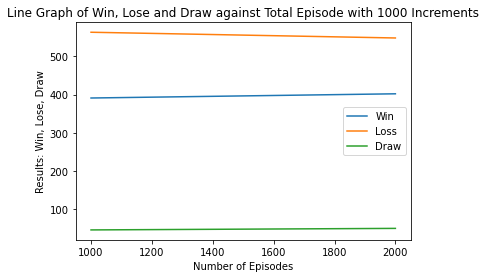

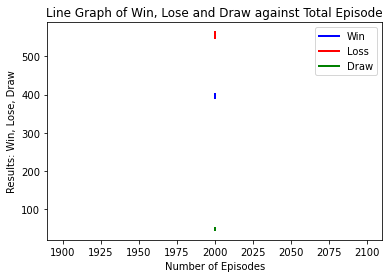

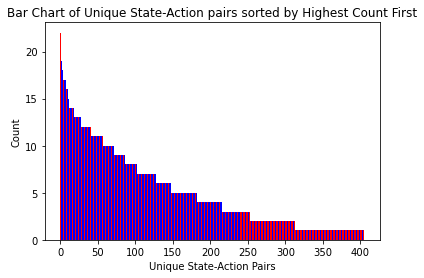


Blackjack strategy table has ace:  {(12, 1): {0: 'H'}, (12, 2): {0: 'H'}, (12, 3): {0: 'H'}, (12, 4): {0: 'H'}, (12, 5): {0: 'H'}, (12, 6): {0: 'H'}, (12, 7): {0: 'H'}, (12, 8): {0: 'H'}, (12, 9): {0: 'H'}, (13, 1): {0: 'H'}, (13, 2): {0: 'H'}, (13, 3): {0: 'H'}, (13, 4): {0: 'H'}, (13, 5): {0: 'H'}, (13, 6): {0: 'H'}, (13, 7): {0: 'H'}, (13, 8): {0: 'H'}, (13, 9): {0: 'H'}, (14, 1): {0: 'H'}, (14, 2): {0: 'H'}, (14, 3): {0: 'H'}, (14, 4): {0: 'S'}, (14, 5): {0: 'H'}, (14, 6): {0: 'H'}, (14, 7): {0: 'S'}, (14, 8): {0: 'H'}, (14, 9): {0: 'S'}, (15, 1): {0: 'H'}, (15, 2): {0: 'H'}, (15, 3): {0: 'H'}, (15, 4): {0: 'H'}, (15, 5): {0: 'H'}, (15, 6): {0: 'H'}, (15, 7): {0: 'H'}, (15, 8): {0: 'H'}, (15, 9): {0: 'H'}, (16, 1): {0: 'H'}, (16, 2): {0: 'H'}, (16, 3): {0: 'H'}, (16, 4): {0: 'H'}, (16, 5): {0: 'H'}, (16, 6): {0: 'H'}, (16, 7): {0: 'H'}, (16, 8): {0: 'H'}, (16, 9): {0: 'H'}, (17, 1): {0: 'H'}, (17, 2): {0: 'H'}, (17, 3): {0: 'H'}, (17, 4): {0: 'H'}, (17, 5): {0: 'S'}, (17, 6): {0: 

In [6]:
if __name__ == "__main__":
    g = Game()
    num_episodes = 2000
    
    win_count = 0
    loss_count = 0
    draw_count = 0
    num_unique4 = 0
    unique_counts = []
    unique_q = []
    
    win = []
    loss = []
    draw = []
    
    mean_win = 0
    mean_loss = 0
    mean_draw = 0
    
    # q(s,a)    
    Q = {}
    N = {}
    
    found = False
    
    for i in range(12,21):
        for j in [True, False]:
            for k in range(1,22):
                Q[(i,j,k)] = {}
                N[(i,j,k)] = {}
                for a in [1,2]:
                    Q[(i,j,k)][a] = 0
                    N[(i,j,k)][a] = 0
    
    for n in range(num_episodes):
        outcome, game_actions = g.start_game((n+1), Q, exploring_starts = False, e_config = 3)
        
        print("Exited game")
        
        if outcome == 1:
            win_count = win_count+1
        elif outcome == 0:
            draw_count = draw_count+1
        elif outcome == -1:
            loss_count = loss_count+1
        
        for i in range(len(game_actions)):
            for k_q, v_q in Q.items():
                for k_n, v_n in N.items():
                    if k_q == game_actions[i][0] and k_n == game_actions[i][0]:
                        v_n[game_actions[i][1]] = v_n[game_actions[i][1]] + 1
                        v_q[game_actions[i][1]] = (v_q[game_actions[i][1]] + ((1/v_n[game_actions[i][1]]) * (outcome - v_q[game_actions[i][1]])))
        
        
        if (((n+1) % 1000) == 0):
            win.append(win_count)
            loss.append(loss_count)
            draw.append(draw_count)
            
            win_count = 0
            loss_count = 0
            draw_count = 0
            
    print("Finished")
    print("\nN: ",N)
    print("\nQ: ",Q) 
    
    for k, v in N.items():
        if v[1] > 0:
            num_unique4 = num_unique4 + 1
            unique_counts.append([(k,1),v[1]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with hit action has q value: ",vq[1])
                    unique_q.append([(k,1),vq[1]])
            #print("State: ", k, " with hit action was selected ",v[1], " number of times.")
        if v[2] > 0:            
            num_unique4 = num_unique4 + 1
            unique_counts.append([(k,2),v[2]])
            for kq, vq in Q.items():
                if kq == k:
                    #print("State: ", k, " with stand action has q value: ",vq[2])
                    unique_q.append([(k,2),vq[2]])
            #print("State: ", k, " with stand action was selected ",v[2], " number of times.")
    
    print("\nNumber of unique state-action pairs, explored after running all episodes: ",num_unique4)
    unique_counts.sort(reverse = True, key = lambda unique_counts : unique_counts[1]) #sorted the list with number of times
#     print("Unique_counts: ",unique_counts)  
#     print("Unique_q: ",unique_q)
#     print("Number of wins per 1000 episodes: ",win)
#     print("Number of losses per 1000 episodes: ",loss)
#     print("Number of draws per 1000 episodes: ",draw)
    
    x = []

    num = int((num_episodes)/1000)

    for i in range(1, num+1):
        x.append(i*1000)

    #plot 1.1
    plt.plot(x, win, label = "Win")
    plt.plot(x, loss, label = "Loss")
    plt.plot(x, draw, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode with 1000 Increments')
    plt.legend()
    plt.show()

    x2 = []
    for i in range(1, num+1):
        x2.append(num_episodes)

    #plot 1.2
    plt.plot(x2, win, color='blue', linewidth = 2, label = "Win")
    plt.plot(x2, loss, color='red', linewidth = 2, label = "Loss")
    plt.plot(x2, draw, color='green', linewidth = 2, label = "Draw")
    plt.xlabel('Number of Episodes')
    plt.ylabel('Results: Win, Lose, Draw')
    plt.title('Line Graph of Win, Lose and Draw against Total Episode')
    plt.legend()
    plt.show()

    #plot 2
    labels, ys = zip(*unique_counts)
    xs = np.arange(len(labels))
    width = 1

    plt.bar(xs, ys, width, align = 'center', color = ['red', 'blue'])
    plt.xlabel('Unique State-Action Pairs')
    plt.ylabel('Count')
    plt.title('Bar Chart of Unique State-Action pairs sorted by Highest Count First')
    plt.show()

    blackjack_strategy_table_ace = {}
    blackjack_strategy_table_no_ace = {}
    
    for i in range(12,21): #between 12 and 20
        for j in range(1,10): #dealers card
                blackjack_strategy_table_ace[(i,j)] = {}
                blackjack_strategy_table_no_ace[(i,j)] = {}
    
    
    for kq2, vq2 in Q.items():
        if vq2[1] >= vq2[2]: 
            best = 'H'
        elif vq2[1] < vq2[2]:
            best = 'S'
            
        if kq2[1] == True:
            #has ace
            for k_a, v_a in blackjack_strategy_table_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
        elif kq2[1] == False:
            #does not have ace
            for k_a, v_a in blackjack_strategy_table_no_ace.items():
                if k_a[0] == kq2[0] and k_a[1] == kq2[2]:
                    v_a[0] = best
    
    print("\nBlackjack strategy table has ace: ", blackjack_strategy_table_ace)
    print("\nBlackjack strategy table no ace: ",blackjack_strategy_table_no_ace)
    
#     if len(win) >= 100 and len(loss) >= 100 and len(draw) >= 100:
#         for i in range(100): #to get the mean for last 100000 episodes 
#             mean_win = mean_win + win[len(win)-1-i]
#             mean_loss = mean_loss + loss[len(loss)-1-i]
#             mean_draw = mean_draw + draw[len(draw)-1-i]
    
#         mean_win = mean_win/100000
#         mean_loss = mean_loss/100000
#         mean_draw = mean_draw/100000
    
    if len(win) >= 2 and len(loss) >= 2 and len(draw)>= 2:
        for i in range(2): #to get the mean for last 2000 episodes 
            mean_win = mean_win + win[len(win)-1-i]
            mean_loss = mean_loss + loss[len(loss)-1-i]
            mean_draw = mean_draw + draw[len(draw)-1-i]
        
        mean_win = mean_win/2000
        mean_loss = mean_loss/2000
        mean_draw = mean_draw/2000
    

    dealer_advantage_no_exploring_3 = ((mean_loss-mean_win)/(mean_loss+mean_win))

### Plots 

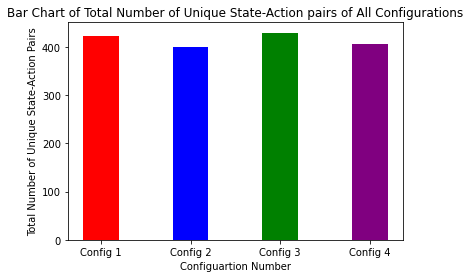

In [7]:
#plot 3
#put the total unique counts and config names in a list
t_unique = []
names = []

names.append('Config 1')
names.append('Config 2')
names.append('Config 3')
names.append('Config 4')

t_unique.append(num_unique)
t_unique.append(num_unique2)
t_unique.append(num_unique3)
t_unique.append(num_unique4)

t_list = list(zip(names,t_unique)) 

#plot 
labels, ys = zip(*t_list)
xs = np.arange(len(labels))


plt.bar(xs, ys, width = 0.4, align = 'center', color = ['red', 'blue', 'green', 'purple'])
plt.xticks(xs, labels) 
plt.yticks()
plt.xlabel('Configuartion Number')
plt.ylabel('Total Number of Unique State-Action Pairs')
plt.title('Bar Chart of Total Number of Unique State-Action pairs of All Configurations')
plt.show()

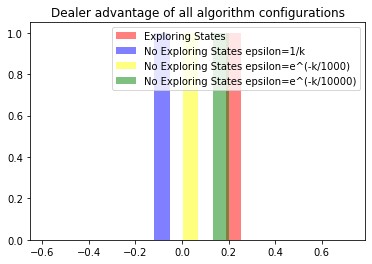

In [8]:
plt.hist(dealer_advantage_exploring, bins=15, alpha=0.5, color = 'red')
plt.hist(dealer_advantage_no_exploring_1, bins=15, alpha=0.5, color = 'blue')
plt.hist(dealer_advantage_no_exploring_2, bins=15, alpha=0.5, color = 'yellow')
plt.hist(dealer_advantage_no_exploring_3, bins=15, alpha=0.5, color = 'green')
plt.title("Dealer advantage of all algorithm configurations")
plt.legend(['Exploring States', 'No Exploring States epsilon=1/k', 'No Exploring States epsilon=e^(-k/1000)', 'No Exploring States epsilon=e^(-k/10000)'])
plt.show()